# Compound Flooding Analysis 

**Objective:** Quantify the relationship between river discharge and offshore water level extremes at the Volta River Estuary to assess compound flooding potential.

**Study Area:**
- Volta River Estuary, Ghana
- Estuary bounds: lat [5.73, 5.83]°, lon [0.64, 0.75]°
- Context bounds for maps: lat [3, 9]°, lon [−3, 3]°
- Reference points: at the mouth river (0.667E  5.77N) and at the Volta Lake (0.117E, 6.5N)

**Datasets:**
- **GloFAS v4.0**: Daily river discharge in the last 24h (`dis24`), units m³/s, 2010–2021.
- **JRC Maximum Daily Global Open Ocean Water Level**: Offshore daily maximum WL, units 10⁻⁴ m, 1959–2021.

**Approach:**
Following Hendry et al. (2019):
1. Pair river and coastal points.
2. Extract extreme events (POT, decluster).
3. Quantify joint occurrences and dependence.


# Import libraries

In [1]:
# Standard library
import os
import glob
import calendar
from calendar import month_abbr
from dataclasses import dataclass

# Scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, multivariate_normal, kendalltau, spearmanr
from scipy.interpolate import griddata
import xarray as xr
from netCDF4 import Dataset

# Visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.dates as mdates

# Geospatial
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
import osmnx as ox

In [2]:
import os, locale

# (facoltativo ma utile) imposta variabili d’ambiente prima
os.environ.pop('LC_ALL', None)  # evita che sovrascriva LC_TIME
# os.environ['LANG'] = 'en_US.UTF-8'  # opzionale

# prova diverse stringhe a seconda del sistema
for loc in ('en_US.UTF-8', 'en_US.utf8', 'English_United States.1252', 'C'):
    try:
        locale.setlocale(locale.LC_TIME, loc)
        print("LC_TIME set to:", loc)
        break
    except locale.Error:
        pass
else:
    print("⚠️ Could not set an English locale; falling back to defaults.")


LC_TIME set to: en_US.UTF-8


In [3]:
# Define useful functions

def detrend_dim(da, dim="time", deg=1, baseline=None, return_trend=False, skipna=True):
    """
    Polynomial detrend along `dim` using xarray's native datetime handling.
    Optionally fit on a `baseline=(start, end)` window, apply to full series.
    """
    da_fit = da.sel({dim: slice(*baseline)}) if baseline else da
    p = da_fit.polyfit(dim=dim, deg=deg, skipna=skipna)
    fit = xr.polyval(da[dim], p.polyfit_coefficients).astype(da.dtype)
    detr = (da - fit).assign_attrs(da.attrs)
    detr.name = (da.name or "var") + "_detrended"
    if return_trend:
        fit.name = (da.name or "var") + "_trend"
        return detr, fit
    return detr

def anom(xarr, baseline=('2010-01-01','2021-12-31')):
    base = xarr.sel(time=slice(*baseline)) if baseline else xarr
    clim = base.groupby('time.month').mean('time')
    ano  = xarr.groupby('time.month') - clim
    return ano, clim

def anomd(xarr, baseline=('2010-01-01','2021-12-31'), deg=1):
    x_det, trend = detrend_dim(xarr, dim='time', deg=deg, baseline=baseline, return_trend=True)
    base_det = x_det.sel(time=slice(*baseline)) if baseline else x_det
    clim_d = base_det.groupby('time.month').mean('time')
    ano_d  = x_det.groupby('time.month') - clim_d
    return ano_d, clim_d, trend


# Study Area

In [4]:
# Define bounds for the Volta River Estuary Area
lat_min, lat_max = 5.73, 5.83
lon_min, lon_max = 0.64, 0.75

# Full map bounds
full_lat_min, full_lat_max = 3, 9
full_lon_min, full_lon_max = -3, 3

# Specific points
lon_estuary, lat_estuary = 0.667, 5.77 # these coordinates are chosen at the estuary, near Ada Foah
lon_lake, lat_lake = 0.087, 6.267 # these are the coordinates of the Volta River just downstream of Volta Lake, close to Akosombo.

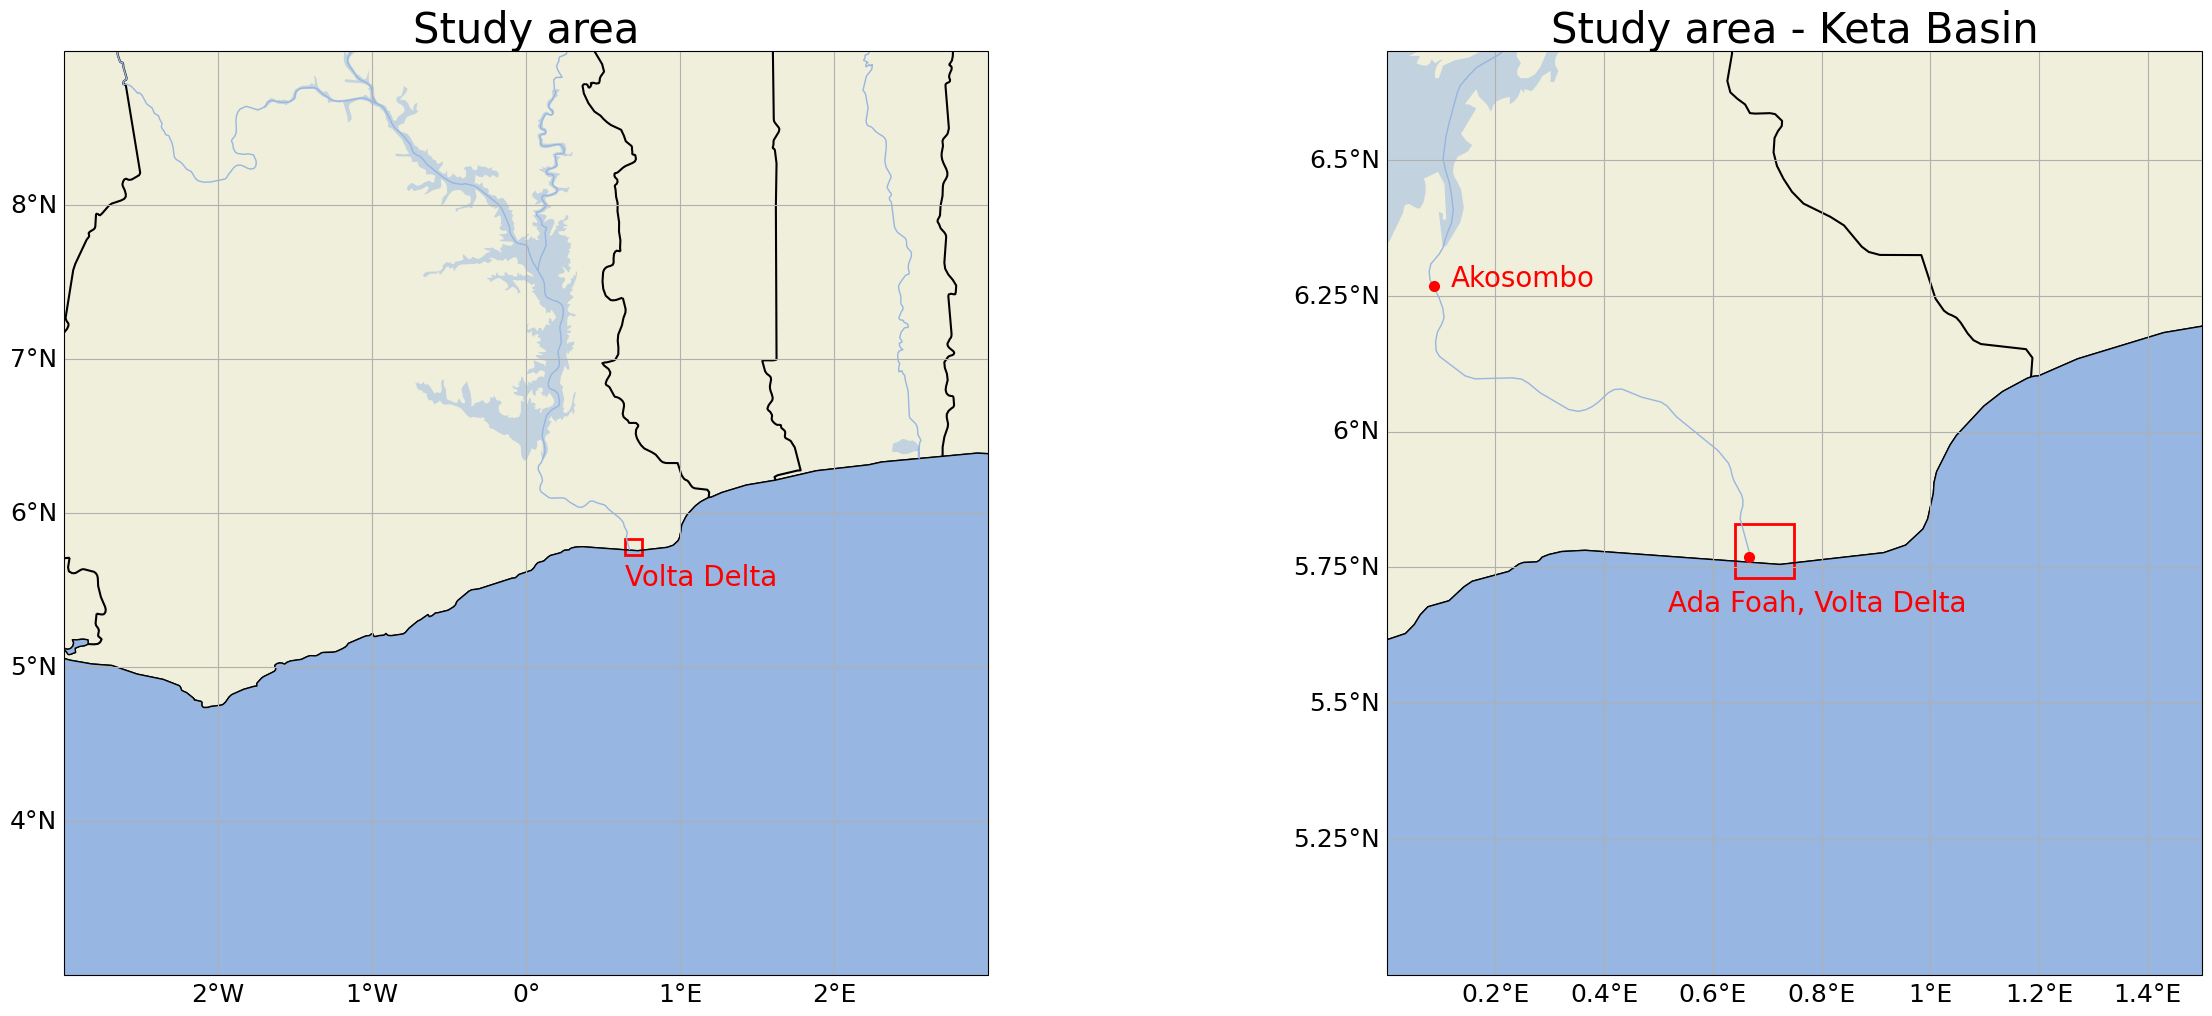

In [5]:
# Create figure and axis with PlateCarree projection
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# First panel: Broad focus Area
ax[0].set_extent([full_lon_min, full_lon_max, full_lat_min, full_lat_max])
ax[0].coastlines(resolution='10m')  # Dettagli costieri
ax[0].add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5)
ax[0].add_feature(cfeature.LAND, edgecolor='black')
ax[0].add_feature(cfeature.RIVERS)
ax[0].add_feature(cfeature.LAKES, alpha=0.5)
ax[0].add_feature(cfeature.OCEAN)
gl0 = ax[0].gridlines(draw_labels=True)
gl0.top_labels = False
gl0.right_labels = False
gl0.xlabel_style = {'fontsize': 18}
gl0.ylabel_style = {'fontsize': 18}
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
ax[0].set_title('Study area', fontsize=30)

# Add rectangle for Keta Estuary subset
from matplotlib.patches import Rectangle

# Add patch (box)
rect = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                 linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax[0].add_patch(rect)
ax[0].text(lon_min, lat_max - 0.3, 'Volta Delta', color='red',
        fontsize=20, transform=ccrs.PlateCarree())


# Second panel: detail over the Volta River Estuary 
ax[1].set_extent([0, 1.5, 5, 6.7])
ax[1].coastlines(resolution='10m')  # Dettagli costieri
ax[1].add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5)
ax[1].add_feature(cfeature.LAND, edgecolor='black')
ax[1].add_feature(cfeature.RIVERS)
ax[1].add_feature(cfeature.LAKES, alpha=0.5)
ax[1].add_feature(cfeature.OCEAN)
gl1 = ax[1].gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'fontsize': 18}
gl1.ylabel_style = {'fontsize': 18}
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
ax[1].set_title('Study area - Keta Basin', fontsize=30)

rect2 = Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                  linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax[1].add_patch(rect2)
ax[1].text(lon_min, lat_max + 0.05, ' ', color='red',
        fontsize=20, transform=ccrs.PlateCarree())
# Add red points 
plt.plot(lon_estuary, lat_estuary, marker='o', color='red', markersize=7)
ax[1].text(lon_estuary -0.15, lat_estuary - 0.1, 'Ada Foah, Volta Delta', color='red',
        fontsize=20, transform=ccrs.PlateCarree())
plt.plot(lon_lake, lat_lake, marker='o', color='red', markersize=7)
ax[1].text(lon_lake + 0.03, lat_lake, 'Akosombo', color='red',
        fontsize=20, transform=ccrs.PlateCarree())


plt.show()

# Load and preprocess data



## GLOFAS data
The GLOFAS dataset, provided by the CEMS Early Warning Data Store, was originally downloaded as GRIB2 files containing the **daily river discharge in the last 24 hours [m³ s⁻¹]** (`dis24`) for the period 2010–2021. Because of their large size, these files were converted into compressed NetCDF format and cropped to the region of interest (3–9°N, –3–3°E).

In the next step, the annual regional NetCDF files (one for each year, covering the Keta Basin, Ghana) are concatenated to produce a single dataset, representing a continuous daily time series of river discharge from 2010 to 2021.

In [6]:
# Working directory
os.chdir("C:/Users/aless/Desktop/dati_tesi/glofas_keta")
files_glofas = sorted(glob.glob("*.nc"))

# Open and concatenate
glofas_ds = [xr.open_dataset(f) for f in files_glofas]
glofas_keta = xr.concat(glofas_ds, dim="time")
glofas_keta

<xarray.Dataset> Size: 252MB
Dimensions:    (time: 4383, latitude: 120, longitude: 120)
Coordinates:
  * latitude   (latitude) float32 480B 3.025 3.075 3.125 ... 8.875 8.925 8.975
  * longitude  (longitude) float32 480B -2.975 -2.925 -2.875 ... 2.925 2.975
  * time       (time) datetime64[ns] 35kB 2010-02-01 2010-02-02 ... 2021-12-31
Data variables:
    dis24      (time, latitude, longitude) float32 252MB 9.999e+03 ... 0.0

Check and sort the `time` variable

In [7]:
# Checking on the 'time' variable

# Get a DatetimeIndex for convenience
t = getattr(glofas_keta.indexes, 'time', pd.DatetimeIndex(glofas_keta['time'].values))

print("Count:", t.size)
print("First :", t[0])
print("Last  :", t[-1])

# Sortedness / monotonicity
print("Monotonic increasing:", t.is_monotonic_increasing)
print("Has duplicates      :", t.has_duplicates)

# Peek at the edges
print("Head:", t[:5].tolist())
print("Tail:", t[-5:].tolist())

# Frequency / regularity
print("Inferred frequency  :", t.inferred_freq)  # None => irregular

# Show where ordering is broken (if any)
bad_order_idx = np.where(t[1:] < t[:-1])[0]
print("Out-of-order indices:", bad_order_idx[:10], "(showing up to 10)")

# Gap summary (how many times each delta occurs)
diffs = pd.Series(t[1:] - t[:-1])
print("Most common gaps:\n", diffs.value_counts().head(5))
print("Unique gaps:", pd.unique(diffs))


Count: 4383
First : 2010-02-01 00:00:00
Last  : 2021-12-31 00:00:00
Monotonic increasing: False
Has duplicates      : False
Head: [Timestamp('2010-02-01 00:00:00'), Timestamp('2010-02-02 00:00:00'), Timestamp('2010-02-03 00:00:00'), Timestamp('2010-02-04 00:00:00'), Timestamp('2010-02-05 00:00:00')]
Tail: [Timestamp('2021-12-27 00:00:00'), Timestamp('2021-12-28 00:00:00'), Timestamp('2021-12-29 00:00:00'), Timestamp('2021-12-30 00:00:00'), Timestamp('2021-12-31 00:00:00')]
Inferred frequency  : None
Out-of-order indices: [ 147  512  878 1243 1608 1973 2339 2704 3069 3434] (showing up to 10)
Most common gaps:
 1 days       4251
31 days        48
32 days        47
63 days        12
-333 days       9
Name: count, dtype: int64
Unique gaps: [    86400000000000   2764800000000000   5443200000000000
 -28771200000000000   2505600000000000   2678400000000000
 -28857600000000000   2592000000000000]


In [8]:
# Show the exact out-of-order transitions (with context)
t = glofas_keta.get_index('time')

bad_idx = np.where(t[1:] < t[:-1])[0]  # indices where next < prev
print("Out-of-order count:", bad_idx.size)

# Show a little neighborhood around each break
for i in bad_idx:
    lo = max(0, i-2)
    hi = min(len(t), i+3)
    print(f"\nBreak at i={i} (t[i] -> t[i+1]):")
    print(pd.Series(t[lo:hi]).to_string())

Out-of-order count: 12

Break at i=147 (t[i] -> t[i+1]):
0   2010-11-28
1   2010-11-29
2   2010-11-30
3   2010-01-01
4   2010-01-02

Break at i=512 (t[i] -> t[i+1]):
0   2011-11-28
1   2011-11-29
2   2011-11-30
3   2011-01-01
4   2011-01-02

Break at i=878 (t[i] -> t[i+1]):
0   2012-11-28
1   2012-11-29
2   2012-11-30
3   2012-01-01
4   2012-01-02

Break at i=1243 (t[i] -> t[i+1]):
0   2013-11-28
1   2013-11-29
2   2013-11-30
3   2013-01-01
4   2013-01-02

Break at i=1608 (t[i] -> t[i+1]):
0   2014-11-28
1   2014-11-29
2   2014-11-30
3   2014-01-01
4   2014-01-02

Break at i=1973 (t[i] -> t[i+1]):
0   2015-11-28
1   2015-11-29
2   2015-11-30
3   2015-01-01
4   2015-01-02

Break at i=2339 (t[i] -> t[i+1]):
0   2016-11-28
1   2016-11-29
2   2016-11-30
3   2016-01-01
4   2016-01-02

Break at i=2704 (t[i] -> t[i+1]):
0   2017-11-28
1   2017-11-29
2   2017-11-30
3   2017-01-01
4   2017-01-02

Break at i=3069 (t[i] -> t[i+1]):
0   2018-11-28
1   2018-11-29
2   2018-11-30
3   2018-01-01
4   2

In [9]:
# Sort by time and verify
glofas_sorted = glofas_keta.sortby('time')

ti = glofas_sorted.get_index('time')
print("Monotonic after sort:", ti.is_monotonic_increasing)
print("Start/End after sort:", ti[0], ti[-1])
print("Inferred freq after sort:", ti.inferred_freq)  # still None if gaps remain


Monotonic after sort: True
Start/End after sort: 2010-01-01 00:00:00 2021-12-31 00:00:00
Inferred freq after sort: D


In [10]:
# Identify and list missing dates (daily grid)
full = pd.date_range(t.min(), t.max(), freq='D')
have = glofas_sorted.time.to_index()

missing = full.difference(have)
print("Missing days:", len(missing))
print("First 20 missing:\n", pd.Series(missing[:20]))

# Optional: summarize missing by year
miss_df = pd.DataFrame({"date": missing})
miss_df["year"] = miss_df["date"].dt.year
print(miss_df["year"].value_counts().sort_index())

Missing days: 0
First 20 missing:
 Series([], dtype: datetime64[ns])
Series([], Name: count, dtype: int64)


In [11]:
# Extract raw (daily) values to the point closest to the two points
rd_estuary = glofas_sorted['dis24'].sel(latitude = lat_estuary, longitude = lon_estuary, method='nearest')
rd_lake = glofas_sorted['dis24'].sel(latitude = lat_lake, longitude = lon_lake, method='nearest')

# confirm where we actually landed
sel_estuary_lat = float(rd_estuary.latitude.values)
sel_estuary_lon = float(rd_estuary.longitude.values)
sel_lake_lat  = float(rd_lake.latitude.values)
sel_lake_lon  = float(rd_lake.longitude.values)
print("Estuary grid cell:",  sel_estuary_lat, sel_estuary_lon)
print("Lake grid cell:",   sel_lake_lat,  sel_lake_lon)


Estuary grid cell: 5.775000095367432 0.675000011920929
Lake grid cell: 6.275000095367432 0.07500000298023224


## Water Level Data
The “Maximum Daily Global Open Ocean Water Level” dataset (JRC) provides a daily time series of offshore maximum water level reconstructed with a statistical PCVAR model. It combines:
* DUACS altimetry sea-level anomalies (sparse satellite observations), and
* ERA5 atmospheric predictors (10-m winds, mean sea-level pressure, pressure gradients),

to produce a continuous daily record even where satellites didn’t pass on a given day.

The key variable is  `waterLevelreanalysis(pointsSAT, time_1959_2021)`, whichi is an open-ocean daily maximum water level signal: captures meteorology such as storm surges and cyclones plus background variability. The units of this daily maximum offshore water level is 10⁻⁴ m (to be converted in m by multiplying by 1e-4).


In [12]:
# Import data from working directory
data_dir = r"C:/Users/aless/Desktop/dati_tesi/globalDailyMaxWaterLevel/VER2024-05-03"
file_jrc = sorted(glob.glob(os.path.join(data_dir, "*.nc")))

# Checking for the presence and validity of files in the working directory
valid_files = []
invalid_files = []

for filepath in file_jrc:
    if os.path.isfile(filepath) and filepath.endswith(".nc"):
        try:
            ds = Dataset(filepath)
            ds.close()
            valid_files.append(filepath)
        except:
            invalid_files.append(filepath)
    else:
        invalid_files.append(filepath)
print(f"✅ Valid NetCDF files: {len(valid_files)}")
print(f"❌ Unreadable NetCDF files: {len(invalid_files)}")

if invalid_files:
    print("Examples of invalid files:")
    for f in invalid_files[:5]:
        print(" -", f)

✅ Valid NetCDF files: 634
❌ Unreadable NetCDF files: 0


In [13]:
# Explore data structure
sample_ds = Dataset(valid_files[0])
print("DATASET INFO:")
print(sample_ds)

print("VARIABLES:")
print(sample_ds.variables.keys())

water_var = sample_ds.variables['waterLevelreanalysis'][:]  
print(f"WATER LEVEL shape: {water_var.shape}")
print(f"TIME VARIABLE:", sample_ds['time_1959_2021'])

sample_ds.close()

sample_xr = xr.open_dataset(valid_files[0])
print(sample_xr)
print(sample_xr.coords)
print(sample_xr.dims)
print(sample_xr['waterLevelreanalysis'].attrs)


DATASET INFO:
<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Institution: European Commission, Directorate-General Joint Research Centre, Disaster Risk Management Unit, Via Enrico Fermi 2749, I-21027-Ispra
    dimensions(sizes): pointsSAT(997), PCR(65), pointsATM(36), time_1959_2021(23011)
    variables(dimensions): float64 AC(pointsSAT), float64 PCRcoef(pointsSAT, PCR), float64 latitudeATM(pointsSAT, pointsATM), float64 latitudeSAT(pointsSAT), float64 longitudeATM(pointsSAT, pointsATM), float64 longitudeSAT(pointsSAT), float64 time_1959_2021(time_1959_2021), int16 waterLevelreanalysis(pointsSAT, time_1959_2021)
    groups: 
VARIABLES:
dict_keys(['AC', 'PCRcoef', 'latitudeATM', 'latitudeSAT', 'longitudeATM', 'longitudeSAT', 'time_1959_2021', 'waterLevelreanalysis'])
WATER LEVEL shape: (997, 23011)
TIME VARIABLE: <class 'netCDF4.Variable'>
float64 time_1959_2021(time_1959_2021)
    units: days since 1950-01-01
unlimited dimensions: time_1959_202

In [14]:
# Open and concatenate datasets
filtered = []
for f in file_jrc:
    ds = xr.open_dataset(f)
    mask = ((ds.longitudeSAT >= full_lon_min) & (ds.longitudeSAT <= full_lon_max) &
            (ds.latitudeSAT  >= full_lat_min) & (ds.latitudeSAT  <= full_lat_max))
    ds = ds.sel(pointsSAT=mask)
    if ds.sizes.get("pointsSAT", 0) > 0:
        filtered.append(ds)

if not filtered:
    raise ValueError("No datasets found within the target region. Check coordinate ranges.")

keta_wl = xr.concat(filtered, dim="pointsSAT", combine_attrs="override")

print("Longitude range:", float(keta_wl.longitudeSAT.min()), "to", float(keta_wl.longitudeSAT.max()))
print("Latitude range:",  float(keta_wl.latitudeSAT.min()),  "to", float(keta_wl.latitudeSAT.max()))
keta_wl

Longitude range: -2.875 to 2.875
Latitude range: 3.125 to 6.375


<xarray.Dataset> Size: 46MB
Dimensions:               (pointsSAT: 249, PCR: 65, pointsATM: 36,
                           time_1959_2021: 23011)
Coordinates:
  * time_1959_2021        (time_1959_2021) datetime64[ns] 184kB 1959-01-01 .....
Dimensions without coordinates: pointsSAT, PCR, pointsATM
Data variables:
    AC                    (pointsSAT) float64 2kB 0.9505 0.9525 ... 0.9446
    PCRcoef               (pointsSAT, PCR) float64 129kB 0.03118 ... -0.0005355
    latitudeATM           (pointsSAT, pointsATM) float64 72kB 3.75 3.5 ... 5.75
    latitudeSAT           (pointsSAT) float64 2kB 3.125 3.375 ... 6.125 6.375
    longitudeATM          (pointsSAT, pointsATM) float64 72kB 356.8 ... 3.5
    longitudeSAT          (pointsSAT) float64 2kB -2.625 -2.625 ... 2.875 2.875
    waterLevelreanalysis  (pointsSAT, time_1959_2021) float64 46MB 390.0 ... ...
Attributes:
    Institution:  European Commission, Directorate-General Joint Research Cen...

Conversion to meters

In [15]:
# Convert to meters (x 1e-4)
# 1) convert to meters in place (respect fill if present)
v = keta_wl["waterLevelreanalysis"]
fill = v.encoding.get("_FillValue", v.attrs.get("_FillValue"))
keta_wl["waterLevelreanalysis"] = (v.where(v != fill) if fill is not None else v) * 1e-4
keta_wl["waterLevelreanalysis"].attrs.update({
    **{k: v.attrs.get(k) for k in v.attrs if k != "units"},
    "units": "m",
    "long_name": "daily maximum offshore water level (meters)",
    "note": "converted from 1e-4 m by multiplying by 1e-4"})

# 2) standardize time coord only if needed
time_name = next((c for c in ["time", "time_1959_2021", "valid_time"] if c in keta_wl.coords), None)
if time_name and time_name != "time":
    keta_wl = keta_wl.rename({time_name: "time"})

Selection of the offshore point nearest to the estuary

In [16]:
dist2 = (keta_wl.latitudeSAT - lat_estuary)**2 + (keta_wl.longitudeSAT - lon_estuary)**2
ip = int(dist2.argmin(dim="pointsSAT").values)

# Filter the period 2010-2021
sel_keta_wl = keta_wl.sel(time=slice("2010-01-01", "2021-12-31"))
# keta_wl_oct = sel_keta_wl.isel(time = sel_keta_wl.time.dt.month == 10)

# Nearest open-ocean point to the river mouth
wl_estuary = sel_keta_wl['waterLevelreanalysis'].isel(pointsSAT=ip)
wl_estuary = wl_estuary.sortby("time")

## Align the daily series (2010-2021)

In [17]:
# River discharge at the estuary
rd = rd_estuary.to_series() # river discharge (m³/s) @ mouth
rd.index = pd.to_datetime(rd.index)

# Water level at offshore point nearest the estuary
wl = wl_estuary.to_series() # water level (m) offshore
wl.index = pd.to_datetime(wl.index)

# intersect dates and drop any NaNs
idx = rd.index.intersection(wl.index)
rd = rd.reindex(idx).dropna()
wl = wl.reindex(idx).dropna()

In [18]:
print(wl_estuary)
print(rd_estuary)
print(rd_lake)

<xarray.DataArray 'waterLevelreanalysis' (time: 4383)> Size: 35kB
array([0.0299, 0.0359, 0.0394, ..., 0.0543, 0.0232, 0.0102], shape=(4383,))
Coordinates:
  * time     (time) datetime64[ns] 35kB 2010-01-01 2010-01-02 ... 2021-12-31
Attributes:
    units:      m
    long_name:  daily maximum offshore water level (meters)
    note:       converted from 1e-4 m by multiplying by 1e-4
<xarray.DataArray 'dis24' (time: 4383)> Size: 18kB
array([616.1094 , 615.6719 , 615.1406 , ..., 621.0469 , 620.28125,
       619.7344 ], shape=(4383,), dtype=float32)
Coordinates:
    latitude   float32 4B 5.775
    longitude  float32 4B 0.675
  * time       (time) datetime64[ns] 35kB 2010-01-01 2010-01-02 ... 2021-12-31
Attributes:
    long_name:  River discharge in the last 24 hours
    units:      m3 s-1
<xarray.DataArray 'dis24' (time: 4383)> Size: 18kB
array([602.84375, 602.75   , 602.71875, ..., 602.875  , 602.84375,
       602.96875], shape=(4383,), dtype=float32)
Coordinates:
    latitude   float32 4B 

# Time variability 

## River Discharge

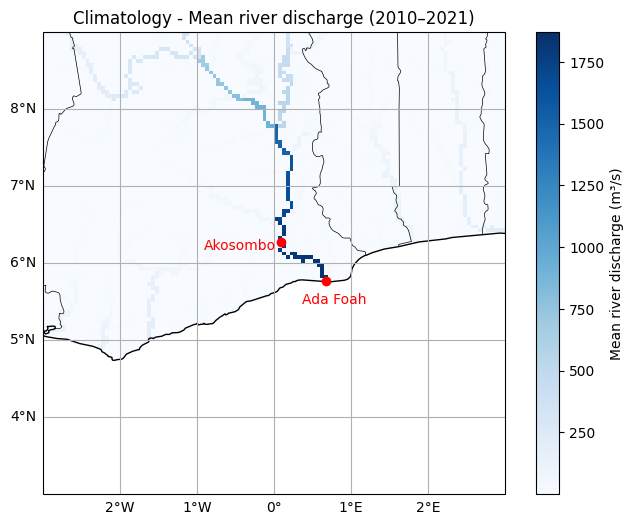

In [ ]:
nodata = 9999.0  # GloFAS missing value

# mask nodata first
glofas_masked = glofas_sorted.where(glofas_sorted.dis24 != nodata)

# climatology
glofas_clim = glofas_masked['dis24'].mean('time')

# plot
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('10m'); ax.add_feature(cfeature.BORDERS, linewidth=0.5)

glofas_clim.plot(
    ax=ax, x='longitude', y='latitude',
    transform=ccrs.PlateCarree(), cmap='Blues',
    cbar_kwargs={'label':'Mean river discharge (m³/s)'}
)

# points (be explicit about transform)
ax.plot(lon_estuary, lat_estuary, 'o', color='red', transform=ccrs.PlateCarree())
ax.text(lon_estuary-0.3, lat_estuary-0.3, 'Ada Foah',
        color='red', transform=ccrs.PlateCarree())
ax.plot(lon_lake, lat_lake, 'o', color='red', transform=ccrs.PlateCarree())
ax.text(lon_lake-1, lat_lake-0.1, 'Akosombo',
        color='red', transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.title('Climatology - Mean river discharge (2010–2021)')
plt.show()


### Temporal variability of the 'raw' climatic index

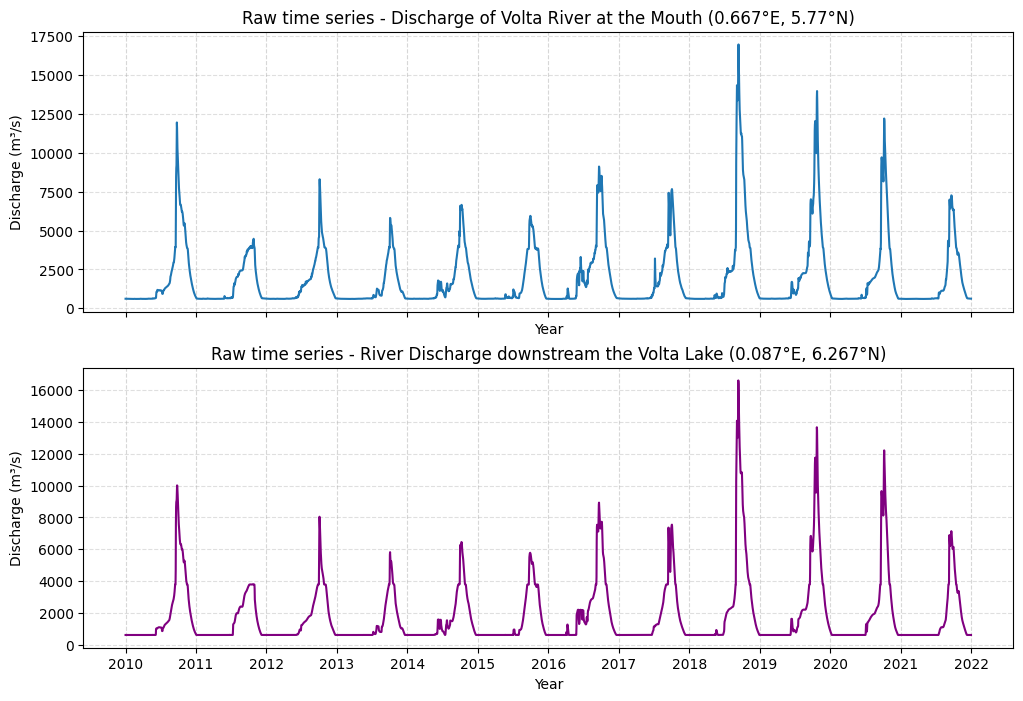

In [ ]:
# Timeseries of River Discharge at the two reference points

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# --- Estuary ---
ax1.plot(rd_estuary.time, rd_estuary, linestyle='-')
ax1.set_title("Raw time series - Discharge of Volta River at the Mouth (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")  
ax1.set_xlabel("Year")
ax1.grid(True)
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)

# --- Volta Lake ---
ax2.plot(rd_lake.time, rd_lake, linestyle='-', color='purple')
ax2.set_title("Raw time series - River Discharge downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")  
ax2.set_xlabel("Year")
# vertical lines: one per month
ax2.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)

import matplotlib.dates as mdates

# one vertical grid line per year
year_loc = mdates.YearLocator()              # every year
year_fmt = mdates.DateFormatter('%Y')

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(year_loc)
    ax.xaxis.set_major_formatter(year_fmt)
    ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)

plt.show()

### Climatology for RD

In [ ]:
# -----------------------------
# Daily climatology and anomaly
# -----------------------------

# drop Feb 29 to get a 365-day climatology
is_feb29e = (rd_estuary.time.dt.month == 2) & (rd_estuary.time.dt.day == 29)
rdE_noleap = rd_estuary.sel(time=~is_feb29e)
rdE_noleap = rdE_noleap.convert_calendar("noleap", dim="time", align_on="date")


is_feb29l = (rd_lake.time.dt.month == 2) & (rd_lake.time.dt.day == 29)
rdL_noleap = rd_lake.sel(time=~is_feb29l)
rdL_noleap = rdL_noleap.convert_calendar("noleap", dim="time", align_on="date")

# --- Daily climatology (2010–2021) ---
rdE_dailyclim = rdE_noleap.groupby('time.dayofyear').mean('time')
rdL_dailyclim = rdL_noleap.groupby('time.dayofyear').mean('time')

dates_clim = pd.date_range("2010-01-01", periods=int(rdE_dailyclim.sizes["dayofyear"]), freq="D")
rdE_dailyclim = rdE_dailyclim.assign_coords(date=("dayofyear", dates_clim))
rdL_dailyclim = rdL_dailyclim.assign_coords(date=("dayofyear", dates_clim))

# --- Daily anomalies (value - daily climatology) ---
def to_datetime64_from_cftime(tcoord):
    return pd.to_datetime([f"{t.year:04d}-{t.month:02d}-{t.day:02d}" for t in tcoord.values])

rdE_dailyanom = rdE_noleap.groupby('time.dayofyear') - rdE_dailyclim
rdE_dailyanom = rdE_dailyanom.assign_coords(date=("time", to_datetime64_from_cftime(rdE_dailyanom["time"])))

rdL_dailyanom = rdL_noleap.groupby('time.dayofyear') - rdL_dailyclim
rdL_dailyanom = rdL_dailyanom.assign_coords(date=("time", to_datetime64_from_cftime(rdL_dailyanom["time"])))

# ---

In [ ]:
# -------------------------------
# Monthly climatology and anomaly
# -------------------------------

# Monthly mean values at the two locations (E = estuary, L = lake)
rdE_mon = rd_estuary.resample(time='MS').mean()   # 'MS' = Month Start
rdL_mon = rd_lake.resample(time='MS').mean()

# Monthly climatology (average over all years for each month)
rdE_clim = rdE_mon.groupby('time.month').mean('time')   # dims: month
rdL_clim = rdL_mon.groupby('time.month').mean('time')

# Anomalies = monthly mean - climatology
rdE_anom = rdE_mon.groupby('time.month') - rdE_clim       # dims: time
rdL_anom = rdL_mon.groupby('time.month') - rdL_clim

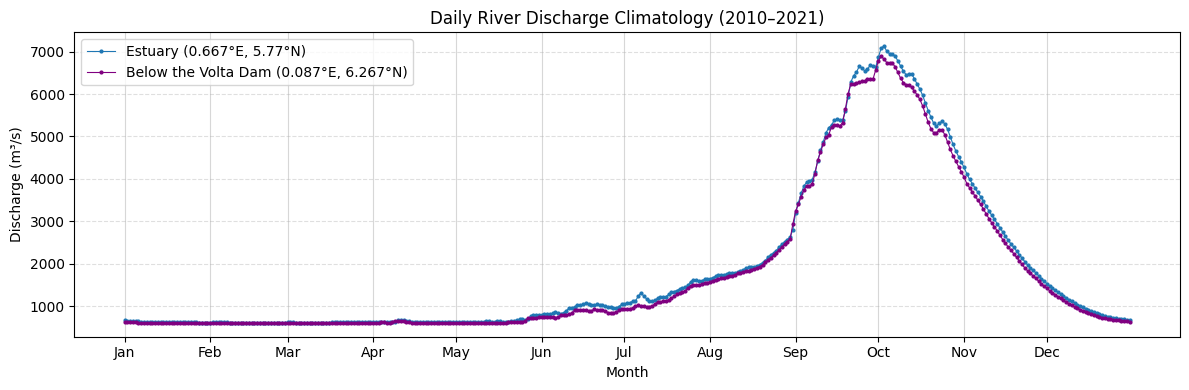

In [ ]:
# Plots
months = list(calendar.month_name)[1:]

# --------------------------------------
# Daily climatology plot RD
# --------------------------------------
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(rdE_dailyclim['date'].values, rdE_dailyclim.values, marker='o', 
        ms=2, lw=0.8, label = 'Estuary (0.667°E, 5.77°N)')
ax.plot(rdL_dailyclim['date'].values, rdL_dailyclim.values, marker = 'o',
        color = 'purple', ms=2, lw=0.8, label ='Below the Volta Dam (0.087°E, 6.267°N)')
ax.set_title("Daily River Discharge Climatology (2010–2021)")
ax.set_ylabel("Discharge (m³/s)")
ax.set_xlabel("Month")
ax.grid(True, axis='x', alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend()

# Tidy monthly ticks
months = pd.date_range('2010-01-01', '2011-01-01', freq='MS')[:-1]
ax.set_xticks(months)
ax.set_xticklabels([m.strftime('%b') for m in months])
plt.tight_layout()
plt.show()

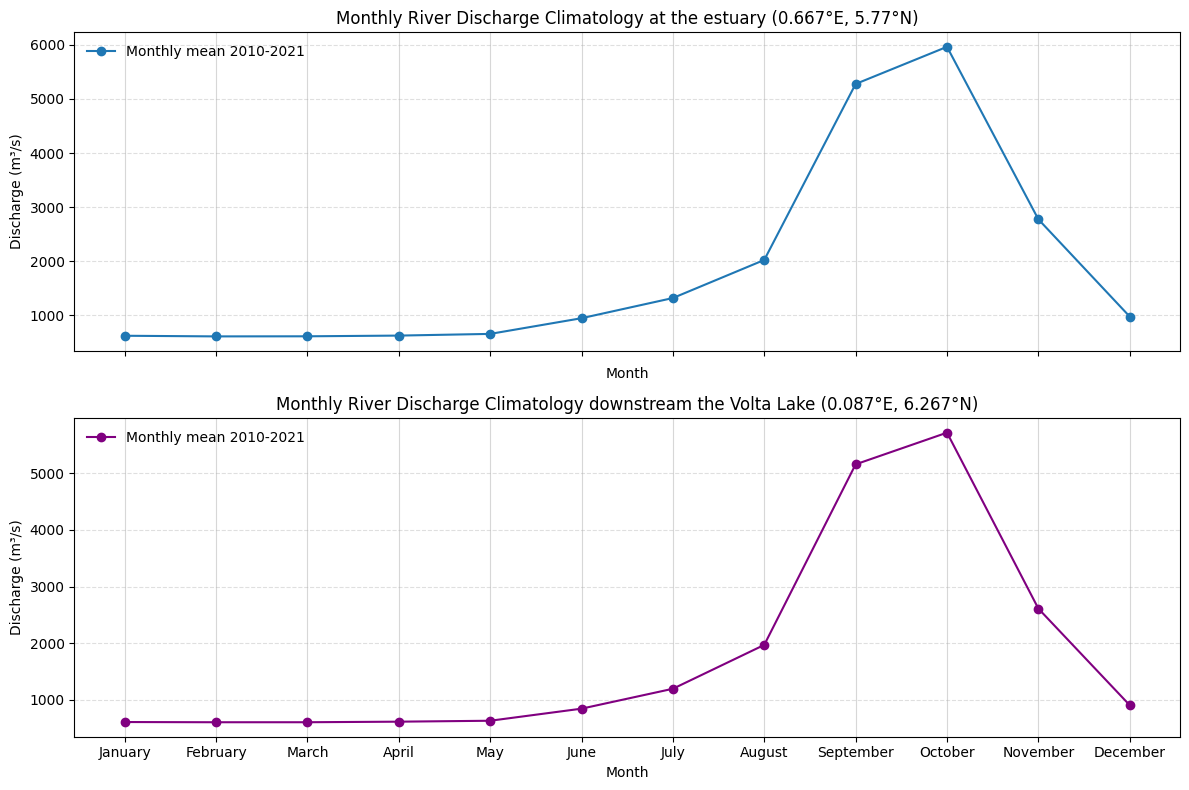

In [ ]:
# --------------------------------------
# Monthly climatology plot RD
# --------------------------------------
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
months = list(calendar.month_name)[1:]

# --- Estuary ---
ax1.plot(rdE_clim['month'].values, rdE_clim.values, marker='o', label = 'Monthly mean 2010-2021')
ax1.set_title("Monthly River Discharge Climatology at the estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month", labelpad=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(loc='upper left', frameon=False)


# --- Volta Lake ---
ax2.plot(rdL_clim['month'].values, rdL_clim.values, color='purple', marker='o', label = 'Monthly mean 2010-2021')
ax2.set_title("Monthly River Discharge Climatology downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month")
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months)
# vertical lines: one per month
ax2.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

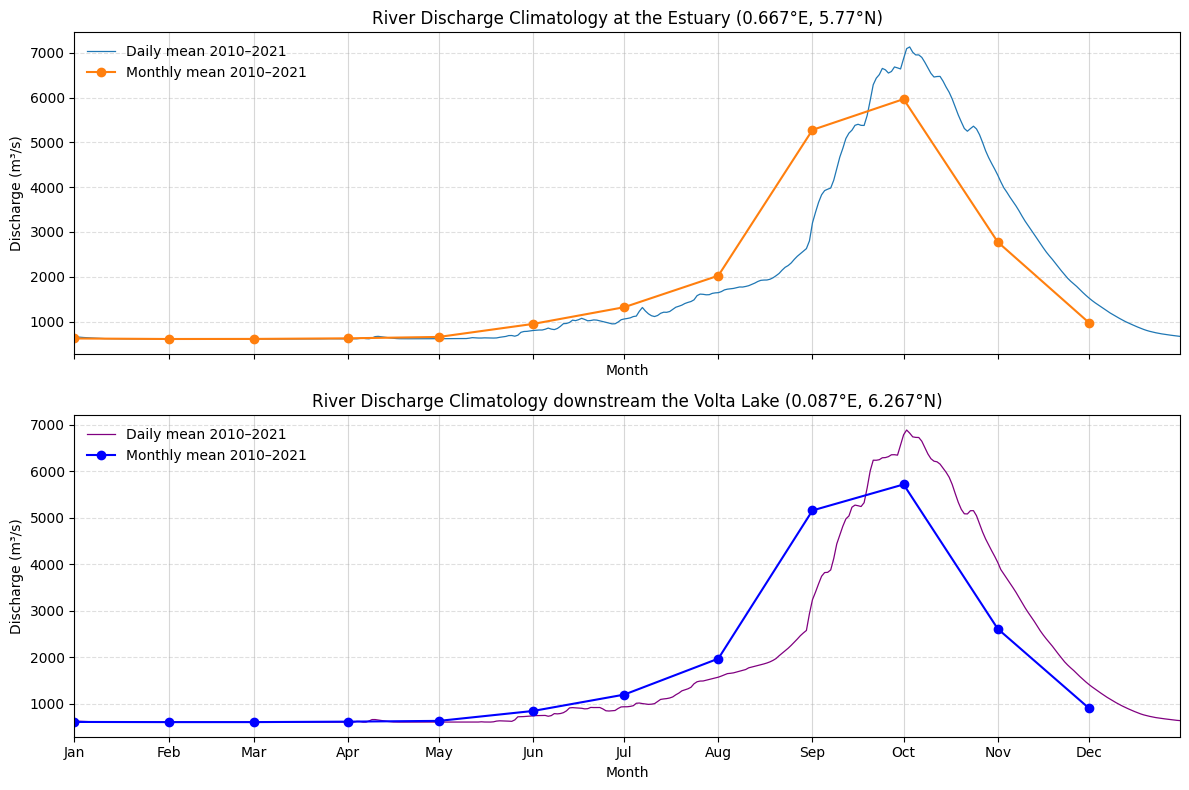

In [ ]:
# -----------------------------------------------
# Daily vs Monthly climatology RD
# -----------------------------------------------

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
# reference year (already non-leap)
year = pd.to_datetime(rdE_dailyclim['date'].values[0]).year
# dates for the monthly (start the month in the same year as daily)
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")

# --- Estuary ---
ax1.plot(rdE_dailyclim['date'].values, rdE_dailyclim.values, lw=0.9, label="Daily mean 2010–2021")
ax1.plot(month_dates, rdE_clim.values, marker='o', label="Monthly mean 2010–2021")

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))

ax1.set_title("River Discharge Climatology at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month")
ax1.grid(True, axis='x', alpha=0.5)
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)
ax1.legend(frameon=False)

# --- Volta Lake ---
ax2.plot(rdL_dailyclim['date'].values, rdL_dailyclim.values, color = 'purple' , lw=0.9, label="Daily mean 2010–2021")
ax2.plot(month_dates, rdL_clim.values, marker='o', color= 'blue',  label="Monthly mean 2010–2021")

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))

ax2.set_title("River Discharge Climatology downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month")
ax2.grid(True, axis='x', alpha=0.5)
ax2.grid(True, axis='y', linestyle='--', alpha=0.4)
ax2.legend(frameon=False)
plt.tight_layout()
plt.show()


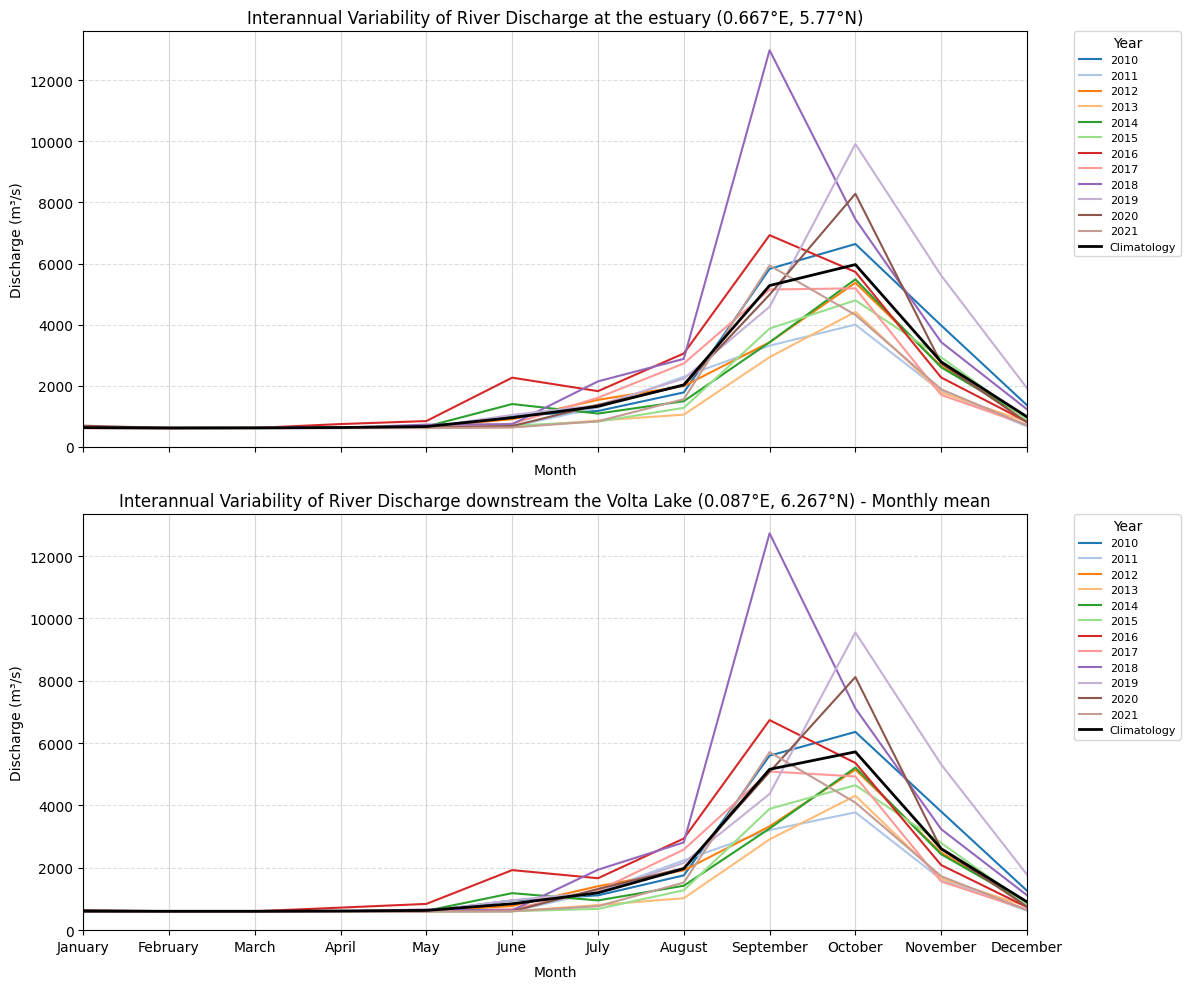

In [ ]:
years = sorted(set(rd_estuary['time'].dt.year.values))

# --------------------------------------
# Monthly mean river discharge
# --------------------------------------

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)
cmap = plt.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(years))]

# --- Estuary ---
for i, (y1, yy1) in enumerate(rdE_mon.groupby('time.year')):
    # yy is the monthly series for that year (up to 12 points)
    ax1.plot(yy1['time.month'].values, yy1.values, label=str(y1), color=colors[i])

ax1.plot(rdE_clim['month'], rdE_clim.values, color='black', label='Climatology', linewidth=2)

ax1.set_title("Interannual Variability of River Discharge at the estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month", labelpad=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.set_xlim(1, 12)
ax1.set_axisbelow(True)
ax1.grid(True, axis='x', which='major', alpha=0.5)             
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8, ncol=1, title="Year")

# --- Volta Lake ---
for j, (y2, yy2) in enumerate(rdL_mon.groupby('time.year')):
    # yy is the monthly series for that year (up to 12 points)
    ax2.plot(yy2['time.month'].values, yy2.values, label=str(y2), color=colors[j])

ax2.plot(rdL_clim['month'], rdL_clim.values, color='black', label='Climatology', linewidth=2)

ax2.set_title("Interannual Variability of River Discharge downstream the Volta Lake (0.087°E, 6.267°N) - Monthly mean")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month", labelpad=8)
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(months)
ax2.set_xlim(1, 12)
ax2.set_axisbelow(True)
ax2.grid(True, axis='x', which='major', alpha=0.5)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8, ncol=1, title="Year")

plt.tight_layout()
plt.show()

### RD anomaly
#### Anomaly without detrending

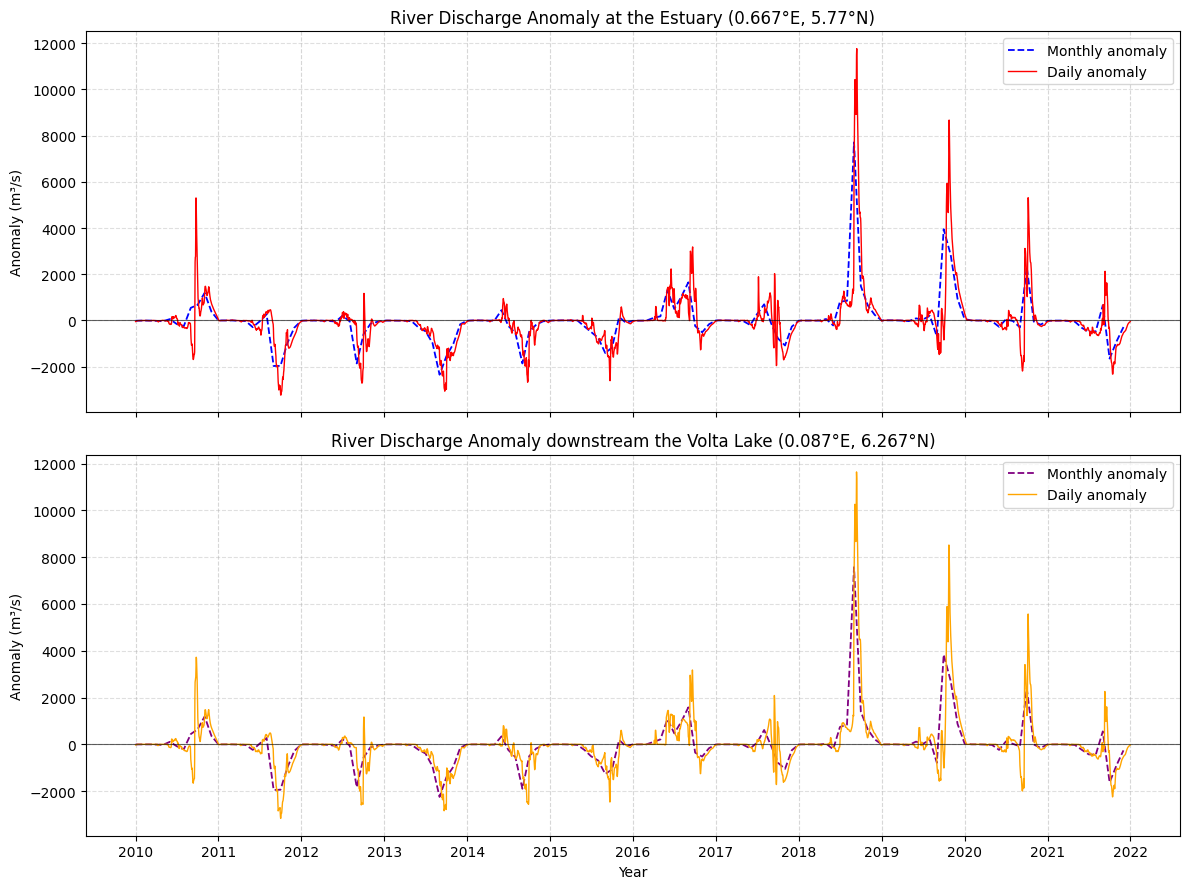

In [ ]:
# Unique years + one extra for right edge
years = np.unique(rdE_dailyanom['time.year'].values)
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex=True)

# --- Estuary ---
ax1.plot(rdE_anom['time'], rdE_anom.values, color='b', linewidth=1.3, linestyle = '--', label = 'Monthly anomaly')
ax1.plot(rdE_dailyanom['date'].values, rdE_dailyanom.values, linewidth=1, color= 'r', label = 'Daily anomaly')
ax1.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax1.set_title("River Discharge Anomaly at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Anomaly (m³/s)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

# --- Volta Lake ---
ax2.plot(rdL_anom['time'], rdL_anom.values, color='purple', linewidth=1.3, linestyle = '--', label = 'Monthly anomaly')
ax2.plot(rdL_dailyanom['date'].values, rdL_dailyanom.values, linewidth=1, color= 'orange', label = 'Daily anomaly')
ax2.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax2.set_title("River Discharge Anomaly downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Anomaly (m³/s)")
ax2.set_xlabel("Year")
ax2.set_xticks(year_ticks)
ax2.set_xticklabels(years_ext)
ax2.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Checking on the highest daily anomaly value
print('Daily anomaly maximum', rdE_dailyanom.max())
print('Happened on the', rdE_dailyanom.idxmax())

Daily anomaly maximum <xarray.DataArray 'dis24' ()> Size: 4B
array(11768.285, dtype=float32)
Happened on the <xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(2018, 9, 13, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)


In [ ]:
# Checking on the highest daily anomaly value
val = rdL_dailyclim.where(rdL_dailyclim['date'] == np.datetime64('2010-09-13'),
                          drop=True).squeeze()
val1 = rd_lake.where(rd_lake['time'] == np.datetime64('2018-09-13'),
                          drop=True).squeeze()
val2 = rdL_dailyanom.where(rdL_dailyanom['date'] == np.datetime64('2018-09-13'),
                          drop=True).squeeze()

print('Daily max climatology:', val.values)
print('Daily river discharge max:', val1.values)
print('Daily max anomaly:', val2.values)

valm = rdE_clim.where(rdE_clim['month'] == 9,
                          drop=True).squeeze()
val1m = rdE_mon.where(rdE_mon['time'] == np.datetime64('2018-09-01'),
                          drop=True).squeeze()
val2m = rdE_anom.where(rdE_anom['time'] == np.datetime64('2018-09-01'),
                          drop=True).squeeze()

print('Monthly max climatology:', valm.values)
print('Monthly river discharge max:', val1m.values)
print('Monthly max anomaly:', val2m.values)


Daily max climatology: 5039.7935
Daily river discharge max: 16393.531
Daily max anomaly: 11353.738
Monthly max climatology: 5277.8867
Monthly river discharge max: 12990.454
Monthly max anomaly: 7712.5674


In [ ]:
# Checking on the lowest daily anomaly value
print('Daily anomaly minimum', rdE_dailyanom.min())
print('Happened on the', rdE_dailyanom.idxmin())

Daily anomaly minimum <xarray.DataArray 'dis24' ()> Size: 4B
array(-3230.8872, dtype=float32)
Happened on the <xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(2011, 10, 3, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)


In [ ]:
# Checking on the highest daily anomaly value
val = rdE_dailyclim.where(rdE_dailyclim['date'] == np.datetime64('2010-10-03'),
                          drop=True).squeeze()
val1 = rd_estuary.where(rd_estuary['time'] == np.datetime64('2011-10-03'),
                          drop=True).squeeze()
val2 = rdE_dailyanom.where(rdE_dailyanom['date'] == np.datetime64('2011-10-03'),
                          drop=True).squeeze()

print('Daily climatology:', val.values)
print('Daily river discharge:', val1.values)
print('Daily anomaly:', val2.values)


Daily climatology: 7129.2466
Daily river discharge: 3898.3594
Daily anomaly: -3230.8872


#### Detrended anomaly
To better understand the variability of a certain climatic index, it is convenient to remove the seasonal cycle from the timeseries by computing the anomaly as the difference between the monthly mean and the long-term monthly mean (the climatology) for each month. In this way we obtain a timesereis of anomaly values that oscillate around the zero (between ...), and that better represent the variability of river discharge in the Keta basin, in Ghana, within the period 2010-2021.

In [ ]:
# --------------------------------------
# Detrended climatologies and anomalies
# --------------------------------------
baseline = ('2010-01-01','2021-12-31')

# helper per assegnare una coord 'date' da cftime -> datetime64
def to_datetime64_from_cftime(tcoord):
    import pandas as pd
    return pd.to_datetime([f"{t.year:04d}-{t.month:02d}-{t.day:02d}" for t in tcoord.values])

# ---------- ESTUARY ----------
# trend and detrended time series
rdE_danom_from_anomd, rdE_clim_from_anomd, rdE_trend = anomd(rd_estuary, baseline=baseline, deg=1)
rdE_detr = rd_estuary - rdE_trend.interp(time=rd_estuary['time'])

# detrended monthly climatology
rdE_dclim_m = rdE_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')

# detrended daily climatology
is_feb29_E = (rdE_detr.time.dt.month == 2) & (rdE_detr.time.dt.day == 29)
rdE_detr_noleap = rdE_detr.sel(time=~is_feb29_E).convert_calendar("noleap", dim="time", align_on="date")
rdE_dclim_d = rdE_detr_noleap.sel(time=slice(*baseline)).groupby('time.dayofyear').mean('time')

dates_clim = pd.date_range("2010-01-01", periods=int(rdE_dclim_d.sizes["dayofyear"]), freq="D")
rdE_dclim_d = rdE_dclim_d.assign_coords(date=("dayofyear", dates_clim))

# detrended anomalies
rdE_danom_d = rdE_detr_noleap.groupby('time.dayofyear') - rdE_dclim_d
rdE_danom_d = rdE_danom_d.assign_coords(date=("time", to_datetime64_from_cftime(rdE_danom_d["time"])))

rdE_danom_m = rdE_detr.resample(time='MS').mean().groupby('time.month') - rdE_dclim_m

# ---------- VOLTA LAKE ----------
# trend and detrended time series
rdL_danom_from_anomd, rdL_clim_from_anomd, rdL_trend = anomd(rd_lake, baseline=baseline, deg=1)
rdL_detr = rd_lake - rdL_trend.interp(time=rd_lake['time'])

# detrended monthly climatology
rdL_dclim_m = rdL_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')

# detrended daily climatology
is_feb29_L = (rdL_detr.time.dt.month == 2) & (rdL_detr.time.dt.day == 29)
rdL_detr_noleap = rdL_detr.sel(time=~is_feb29_L).convert_calendar("noleap", dim="time", align_on="date")
rdL_dclim_d = rdL_detr_noleap.sel(time=slice(*baseline)).groupby('time.dayofyear').mean('time')

dates_clim = pd.date_range("2010-01-01", periods=int(rdL_dclim_d.sizes["dayofyear"]), freq="D")
rdL_dclim_d = rdL_dclim_d.assign_coords(date=("dayofyear", dates_clim))

# detrended anomalies
rdL_danom_d = rdL_detr_noleap.groupby('time.dayofyear') - rdL_dclim_d
rdL_danom_d = rdL_danom_d.assign_coords(date=("time", to_datetime64_from_cftime(rdL_danom_d["time"])))

rdL_danom_m = rdL_detr.resample(time='MS').mean().groupby('time.month') - rdL_dclim_m


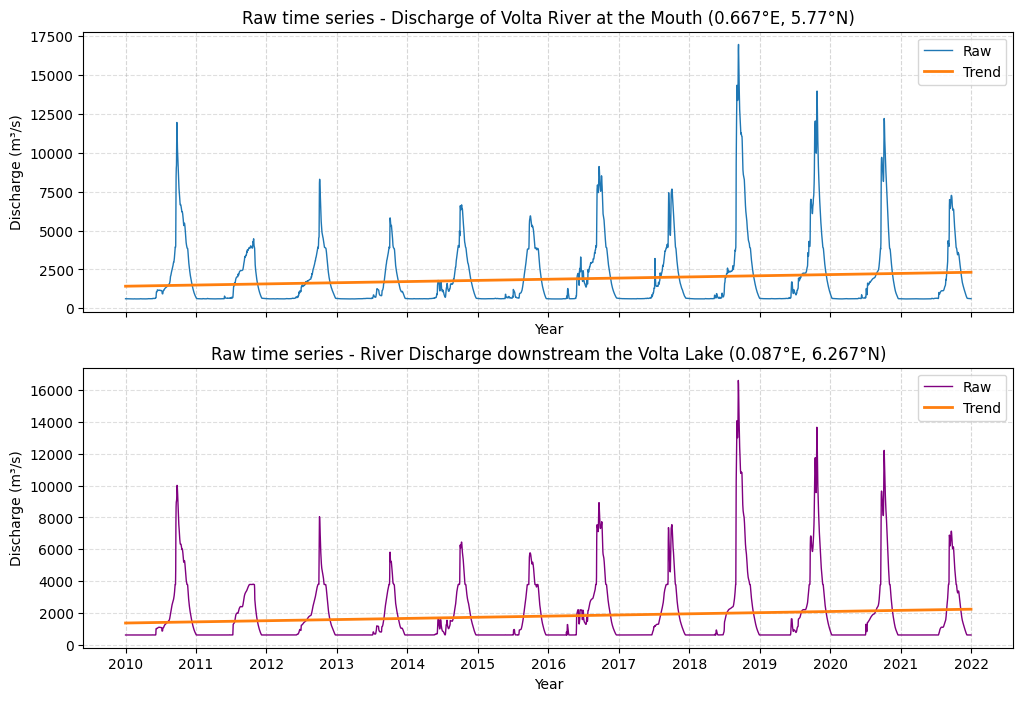

In [ ]:
# Timeseries of River Discharge at the two reference points

# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# --- Estuary ---
ax1.plot(rd_estuary.time, rd_estuary, linestyle='-', lw = 1, label = 'Raw')
ax1.plot(rdE_trend['time'], rdE_trend, linewidth=2, label="Trend", color="tab:orange")
ax1.set_title("Raw time series - Discharge of Volta River at the Mouth (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")  
ax1.set_xlabel("Year")
ax1.grid(True)
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

# --- Volta Lake ---
ax2.plot(rd_lake.time, rd_lake, linestyle='-', lw = 1, color='purple', label = 'Raw')
ax2.plot(rdL_trend['time'], rdL_trend, linewidth=2, label="Trend", color="tab:orange")
ax2.set_title("Raw time series - River Discharge downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")  
ax2.set_xlabel("Year")
# vertical lines: one per month
ax2.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend()

import matplotlib.dates as mdates

# one vertical grid line per year
year_loc = mdates.YearLocator()              # every year
year_fmt = mdates.DateFormatter('%Y')

for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(year_loc)
    ax.xaxis.set_major_formatter(year_fmt)
    ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)

plt.show()

In [ ]:
def trend_stats(trend_da, raw_da, baseline):
    tr = trend_da.sel(time=slice(*baseline))
    t = tr['time'].dt.year + (tr['time'].dt.dayofyear - 1)/365.25
    m, c = np.polyfit(t, tr.values, 1)  # m ≈ m³/s per year
    mean_base = float(raw_da.sel(time=slice(*baseline)).mean())
    return {
        "slope_m3s_per_year": float(m),
        "slope_m3s_per_decade": float(m*10),
        "delta_over_baseline_m3s": float(tr.values[-1]-tr.values[0]),
        "percent_per_decade": float(100*(m*10)/mean_base),
        "baseline_mean_m3s": mean_base,
    }

E = trend_stats(rdE_trend, rd_estuary, baseline)
L = trend_stats(rdL_trend, rd_lake, baseline)
print("Estuary:", E)
print("Lake:", L)


Estuary: {'slope_m3s_per_year': 74.80414250735267, 'slope_m3s_per_decade': 748.0414250735266, 'delta_over_baseline_m3s': 897.4322509765625, 'percent_per_decade': 39.982029840084614, 'baseline_mean_m3s': 1870.944091796875}
Lake: {'slope_m3s_per_year': 72.46451901881483, 'slope_m3s_per_decade': 724.6451901881483, 'delta_over_baseline_m3s': 869.363525390625, 'percent_per_decade': 40.46825095416305, 'baseline_mean_m3s': 1790.651123046875}


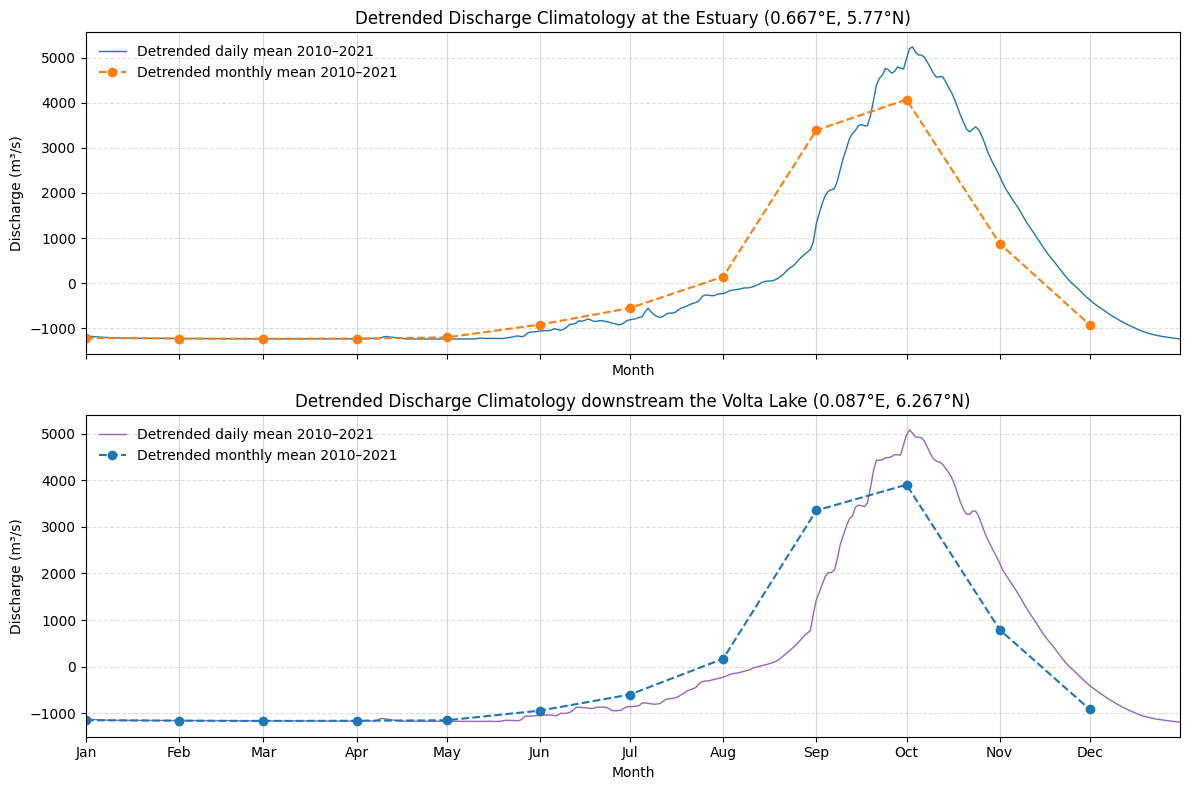

In [ ]:
# -----------------------------------------------
# Daily vs Monthly detrended climatology plot
# -----------------------------------------------

import matplotlib.dates as mdates  # <-- missing import

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# reference year (already non-leap)
year = pd.to_datetime(rdE_dclim_d['date'].values[0]).year
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")

# --- Estuary (detrended) ---
ax1.plot(rdE_dclim_d['date'].values, rdE_dclim_d.values, lw=1, label="Detrended daily mean 2010–2021")
ax1.plot(month_dates, rdE_dclim_m.values, marker='o', linestyle='--', label="Detrended monthly mean 2010–2021")

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))
ax1.set_title("Detrended Discharge Climatology at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Discharge (m³/s)")
ax1.set_xlabel("Month")
ax1.grid(True, axis='x', alpha=0.5)
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)
ax1.legend(frameon=False)

# --- Volta Lake (detrended) ---
ax2.plot(rdL_dclim_d['date'].values, rdL_dclim_d.values, color='tab:purple', lw=1, label="Detrended daily mean 2010–2021")
ax2.plot(month_dates, rdL_dclim_m.values, marker='o', linestyle='--', color='tab:blue', label="Detrended monthly mean 2010–2021")

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax2.set_xlim(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-12-31"))
ax2.set_title("Detrended Discharge Climatology downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Discharge (m³/s)")
ax2.set_xlabel("Month")
ax2.grid(True, axis='x', alpha=0.5)
ax2.grid(True, axis='y', linestyle='--', alpha=0.4)
ax2.legend(frameon=False)

plt.tight_layout()
plt.show()


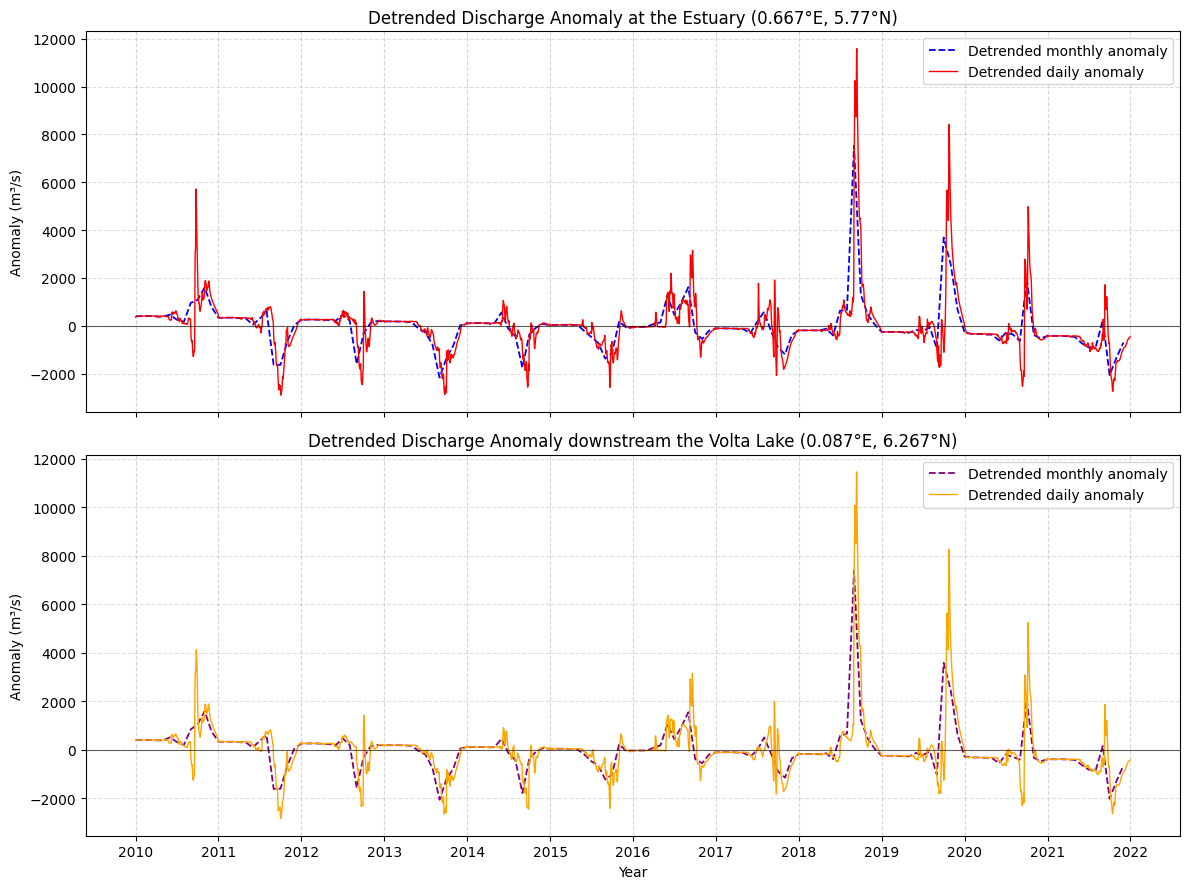

In [ ]:
# --------------------------------------
# Daily vs Monthly detrended anomalies 
# --------------------------------------
# Unique years + one extra for right edge
years = np.unique(rdE_danom_d['time.year'].values)
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex=True)

# --- Estuary ---
ax1.plot(rdE_danom_m['time'], rdE_danom_m.values, color='b', linewidth=1.3, linestyle = '--', label = 'Detrended monthly anomaly')
ax1.plot(rdE_danom_d['date'].values, rdE_danom_d.values, linewidth=1, color= 'r', label = 'Detrended daily anomaly')
ax1.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax1.set_title("Detrended Discharge Anomaly at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Anomaly (m³/s)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

# --- Volta Lake ---
ax2.plot(rdL_danom_m['time'], rdL_danom_m.values, color='purple', linewidth=1.3, linestyle = '--', label = 'Detrended monthly anomaly')
ax2.plot(rdL_danom_d['date'].values, rdL_danom_d.values, linewidth=1, color= 'orange', label = 'Detrended daily anomaly')
ax2.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax2.set_title("Detrended Discharge Anomaly downstream the Volta Lake (0.087°E, 6.267°N)")
ax2.set_ylabel("Anomaly (m³/s)")
ax2.set_xlabel("Year")
ax2.set_xticks(year_ticks)
ax2.set_xticklabels(years_ext)
ax2.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax2.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()


## NO

In [ ]:
#---------------------------------------
# Detrended climatologies and anomalies
#---------------------------------------

# ---------- CONFIGURATION ----------
baseline = ('2010-01-01','2021-12-31')
series = [
    ("Volta River at the Mouth", rd_estuary),
    ("Volta River downstream the Volta Lake", rd_lake),
]

# ---------- PIPELINE ----------
def prep_series(xarr, baseline=baseline, deg=1):
    """Compute detrended monthly and daily anomalies, climatology, and fitted trend."""
    rd_danom, rd_dclim_d, rd_trend = anomd(xarr, baseline=baseline, deg=deg)

    # ensure regular daily & monthly versions (mean if already daily)
    rd_danom_d = rd_danom.resample(time='D').mean()
    rd_danom_m = rd_danom.resample(time='MS').mean()

    # detrended base for monthly climatology
    x_detr = xarr - rd_trend.interp(time=xarr['time'])
    rd_dclim_m = x_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')
    
    return {"raw": xarr, 
            "rd_danom_m": rd_danom_m, # monthly anomaly
            "rd_danom_d": rd_danom_d, # daily anomaly
            "rd_dclim_d": rd_dclim_d, # daily climatology
            "rd_dclim_m": rd_dclim_m, # monthly climatology
            "rd_trend": rd_trend}

# run for all series
results = {name: prep_series(xarr, baseline=baseline) for name, xarr in series}



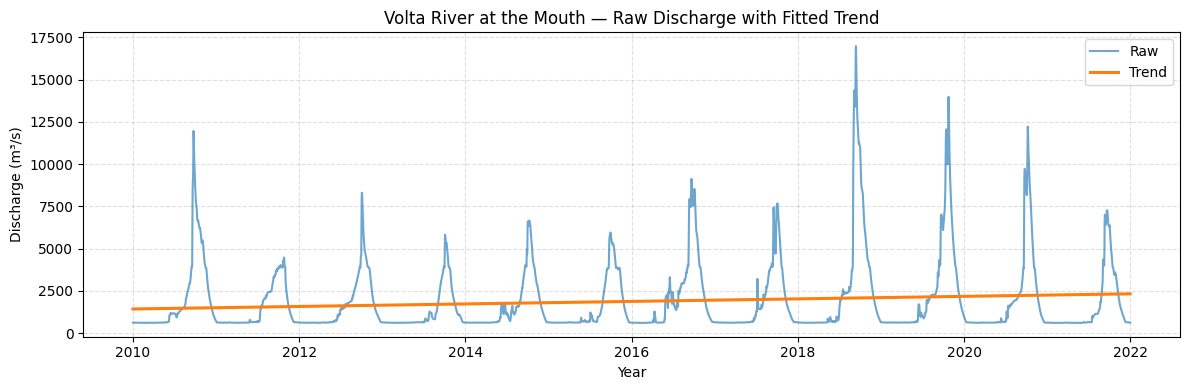

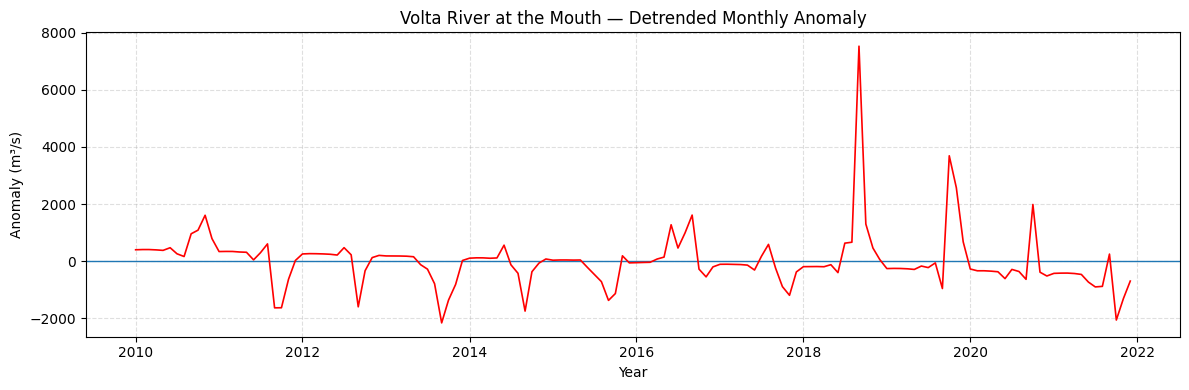

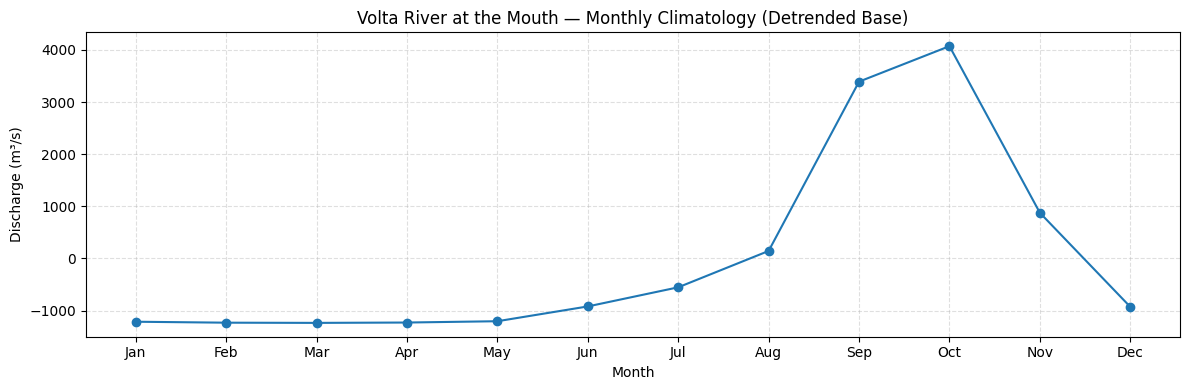

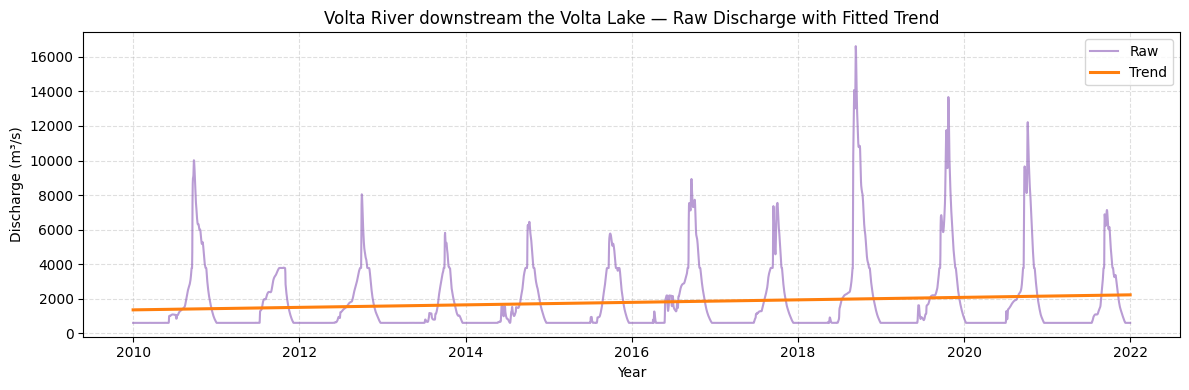

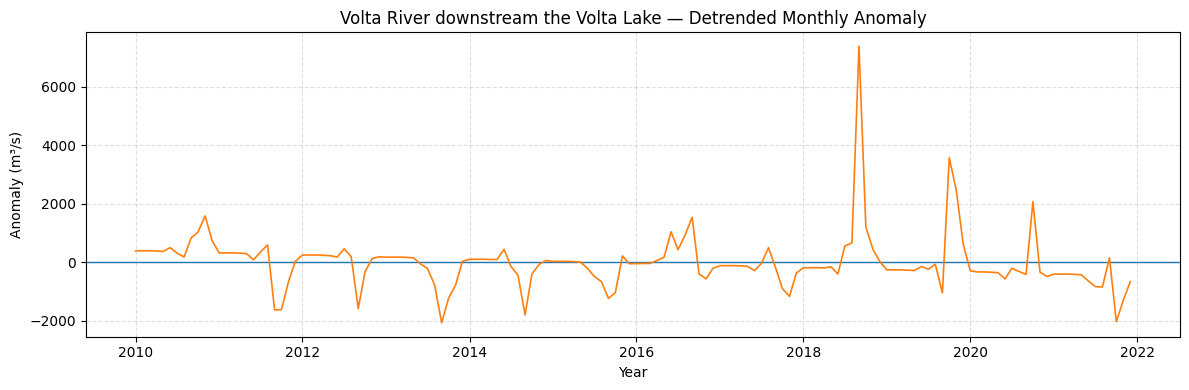

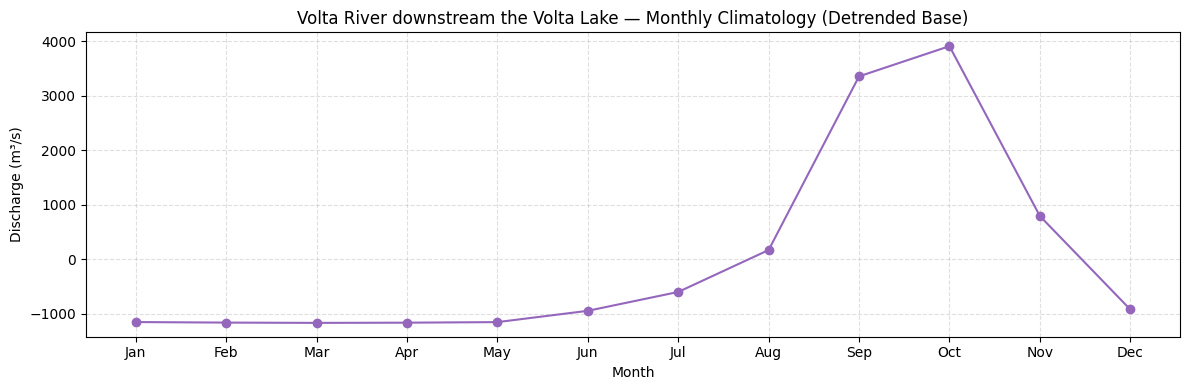

In [ ]:
#----------------------------
# Detrended monthly plots
#----------------------------

# color map by location
COLORSc = {"Volta River at the Mouth": "tab:blue",            # blue
    "Volta River downstream the Volta Lake": "tab:purple"  # purple
}
COLORSa = {"Volta River at the Mouth": "r",            # blue
    "Volta River downstream the Volta Lake": "tab:orange"  # purple
}

def plot_raw_with_trend(name, raw, rd_trend):
    c = COLORSc.get(name, None)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(raw['time'], raw, linewidth=1.5, label="Raw", color=c, alpha=0.65)
    ax.plot(rd_trend['time'], rd_trend, linewidth=2.2, label="Trend", color="tab:orange")
    ax.set_title(f"{name} — Raw Discharge with Fitted Trend")
    ax.set_ylabel("Discharge (m³/s)"); ax.set_xlabel("Year")
    ax.grid(True, which='major', linestyle='--', alpha=0.4)
    ax.legend()
    plt.tight_layout(); plt.show()

def plot_climatology(name, rd_dclim_m):
    c = COLORSc.get(name, None)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(rd_dclim_m['month'], rd_dclim_m, marker='o', color=c)
    ax.set_title(f"{name} — Monthly Climatology (Detrended Base)")
    ax.set_xticks(range(1,13))
    ax.set_xticklabels([month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel("Month"); ax.set_ylabel("Discharge (m³/s)")
    ax.grid(True, which='major', linestyle='--', alpha=0.4)
    plt.tight_layout(); plt.show()


def plot_anomaly(name, rd_danom_m):
    c = COLORSa.get(name, None)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.axhline(0, linewidth=1)
    ax.plot(rd_danom_m['time'], rd_danom_m, linewidth=1.2, color= c)
    ax.set_title(f"{name} — Detrended Monthly Anomaly")
    ax.set_ylabel("Anomaly (m³/s)"); ax.set_xlabel("Year")
    ax.grid(True, which='major', linestyle='--', alpha=0.4)
    plt.tight_layout(); plt.show()
    
# ---------- RUN FOR ALL SERIES ----------
results = {name: prep_series(xarr, baseline=baseline) for name, xarr in series}

for name, r in results.items():
    plot_raw_with_trend(name, r["raw"], r["rd_trend"])
    plot_anomaly(name, r["rd_danom_m"])
    plot_climatology(name, r["rd_dclim_m"])

rdE_danom_m = results["Volta River at the Mouth"]["rd_danom_m"]   # DataArray (time)
rdE_dclim   = results["Volta River at the Mouth"]["rd_dclim_m"]     # DataArray (month)
rdE_trend   = results["Volta River at the Mouth"]["rd_trend"]
rdE_raw     = results["Volta River at the Mouth"]["raw"]

rdL_danom_m = results["Volta River downstream the Volta Lake"]["rd_danom_m"]
rdL_dclim   = results["Volta River downstream the Volta Lake"]["rd_dclim_m"]
rdL_trend   = results["Volta River downstream the Volta Lake"]["rd_trend"]
rdL_raw     = results["Volta River downstream the Volta Lake"]["raw"]

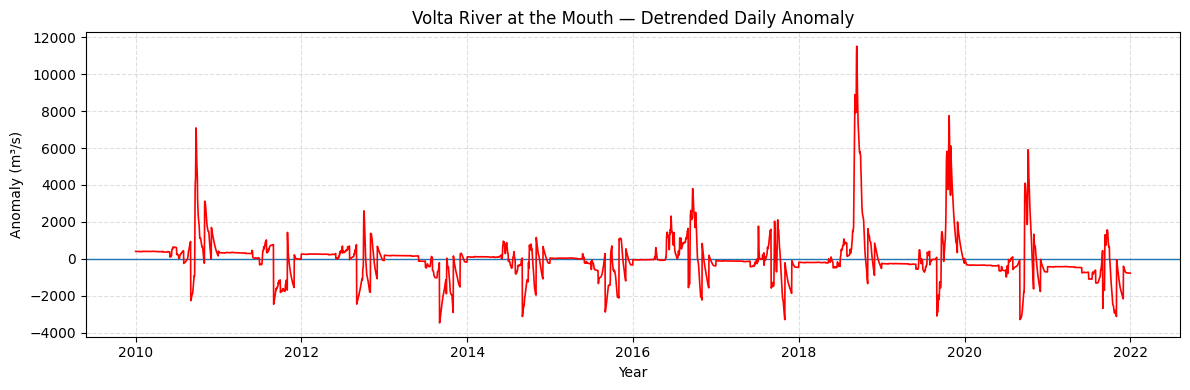

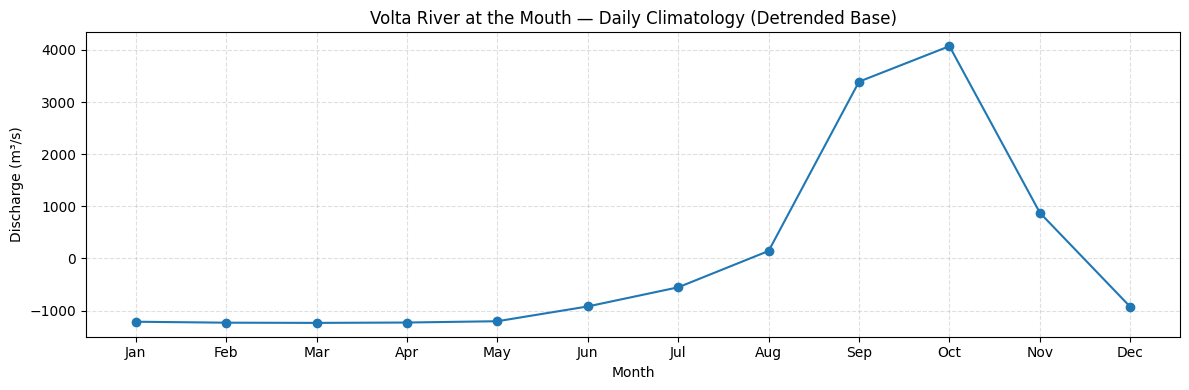

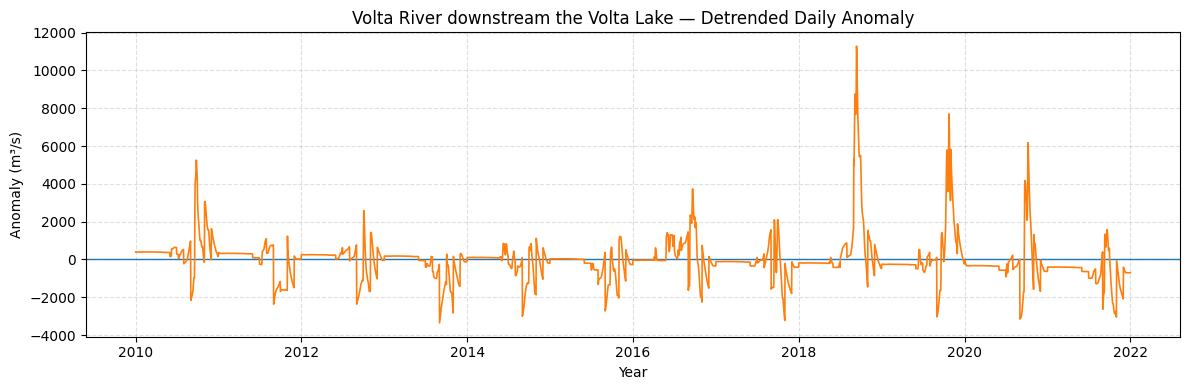

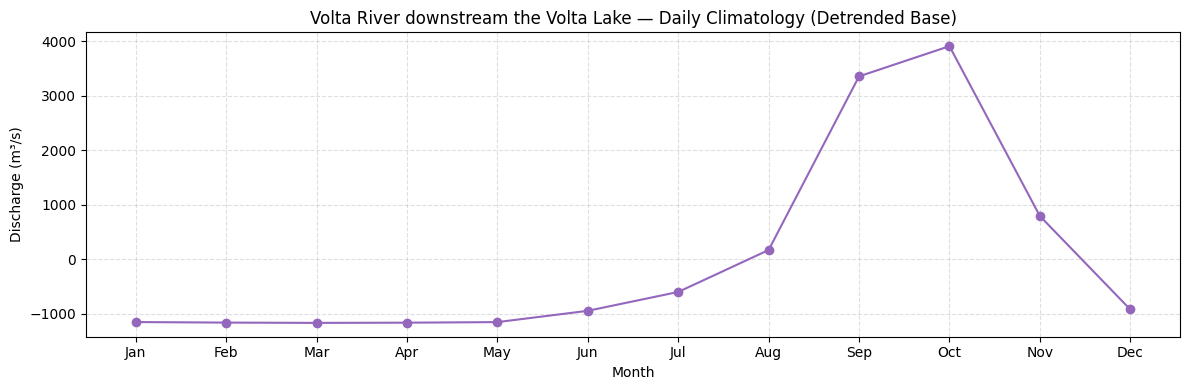

In [ ]:
#----------------------------
# Detrended daily plots
#----------------------------

def plot_climatology(name, rd_dclim_d):
    c = COLORSc.get(name, None)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(rd_dclim_d['month'], rd_dclim_d, marker='o', color=c)
    ax.set_title(f"{name} — Daily Climatology (Detrended Base)")
    ax.set_xticks(range(1,13))
    ax.set_xticklabels([month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel("Month"); ax.set_ylabel("Discharge (m³/s)")
    ax.grid(True, which='major', linestyle='--', alpha=0.4)
    plt.tight_layout(); plt.show()


def plot_anomaly(name, rd_danom_d):
    c = COLORSa.get(name, None)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.axhline(0, linewidth=1)
    ax.plot(rd_danom_d['time'], rd_danom_d, linewidth=1.2, color = c)
    ax.set_title(f"{name} — Detrended Daily Anomaly")
    ax.set_ylabel("Anomaly (m³/s)"); ax.set_xlabel("Year")
    ax.grid(True, which='major', linestyle='--', alpha=0.4)
    plt.tight_layout(); plt.show()
    
# ---------- RUN FOR ALL SERIES ----------
results = {name: prep_series(xarr, baseline=baseline) for name, xarr in series}

for name, r in results.items():
    plot_anomaly(name, r["rd_danom_d"])
    plot_climatology(name, r["rd_dclim_d"])

rdE_danom_m = results["Volta River at the Mouth"]["rd_danom_d"]   # DataArray (time)
rdE_dclim   = results["Volta River at the Mouth"]["rd_dclim_d"]     # DataArray (month)
rdE_trend   = results["Volta River at the Mouth"]["rd_trend"]
rdE_raw     = results["Volta River at the Mouth"]["raw"]

rdL_danom_m = results["Volta River downstream the Volta Lake"]["rd_danom_d"]
rdL_dclim   = results["Volta River downstream the Volta Lake"]["rd_dclim_d"]
rdL_trend   = results["Volta River downstream the Volta Lake"]["rd_trend"]
rdL_raw     = results["Volta River downstream the Volta Lake"]["raw"]

## Water level
### Temporal variability of the 'raw' climatic index

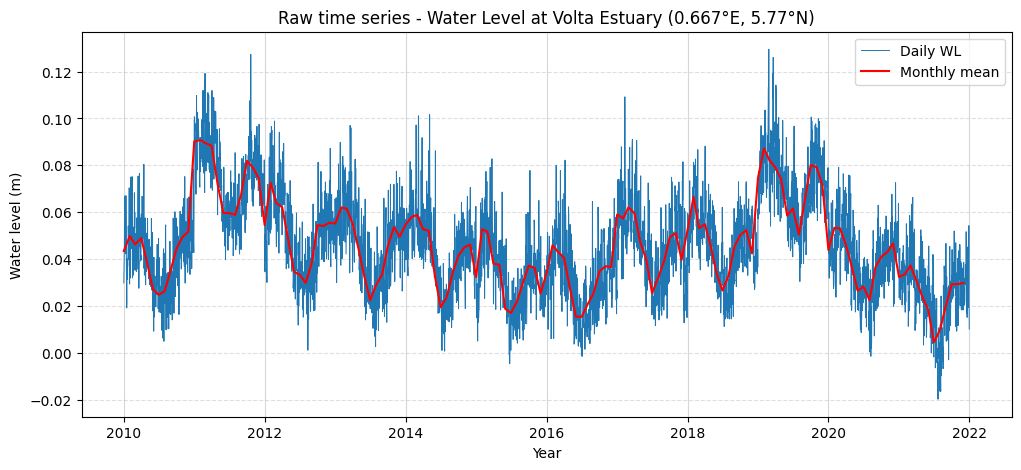

In [ ]:
# Timeseries of Water Level

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)
ax1.plot(wl_estuary.time, wl_estuary, linestyle='-', lw=0.7, label = 'Daily WL')
# Monthly mean values at the two locations (E = estuary, L = lake)
wl_mon = wl_estuary.resample(time='MS').mean()   # 'MS' = Month Start

ax1.plot(wl_mon.time, wl_mon, linestyle = '-', color = 'r', label = 'Monthly mean')
ax1.set_title("Raw time series - Water Level at Volta Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Water level (m)")  
ax1.set_xlabel("Year")
ax1.grid(True)
ax1.legend()
# vertical lines: one per month
ax1.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)

#plt.tight_layout()
plt.show()

In [ ]:
from spicy import stats
stats.describe(wl_estuary)

DescribeResult(nobs=4383, minmax=(np.float64(-0.019700000000000002), np.float64(0.1295)), mean=np.float64(0.045751768195300024), variance=np.float64(0.0004593093481963684), skewness=np.float64(0.3702149632005382), kurtosis=np.float64(-0.004296589993163735))

### Climatology for WL

In [ ]:
# -----------------------------
# Daily climatology and anomaly
# -----------------------------

# drop Feb 29 to get a 365-day climatology
is_feb29w = (wl_estuary.time.dt.month == 2) & (wl_estuary.time.dt.day == 29)
wl_noleap = wl_estuary.sel(time=~is_feb29w)
wl_noleap = wl_noleap.convert_calendar("noleap", dim="time", align_on="date")

# --- Daily climatology (2010–2021) ---
wl_dailyclim = wl_noleap.groupby('time.dayofyear').mean('time')
wl_dailyclim = wl_noleap.groupby('time.dayofyear').mean('time')

dates_climw = pd.date_range("2010-01-01", periods=int(wl_dailyclim.sizes["dayofyear"]), freq="D")
wl_dailyclim = wl_dailyclim.assign_coords(date=("dayofyear", dates_climw))

# --- Daily anomalies (value - daily climatology) ---
def to_datetime64_from_cftime(tcoord):
    return pd.to_datetime([f"{t.year:04d}-{t.month:02d}-{t.day:02d}" for t in tcoord.values])

wl_dailyanom = wl_noleap.groupby('time.dayofyear') - wl_dailyclim
wl_dailyanom = wl_dailyanom.assign_coords(date=("time", to_datetime64_from_cftime(wl_dailyanom["time"])))

# -------------------------------
# Monthly climatology and anomaly
# -------------------------------

# Monthly mean values at the two locations (E = estuary, L = lake)
wl_mon = wl_estuary.resample(time='MS').mean()   # 'MS' = Month Start

# Monthly climatology (average over all years for each month)
wl_clim = wl_mon.groupby('time.month').mean('time')   # dims: month

# Anomalies = monthly mean - climatology
wl_anom = wl_mon.groupby('time.month') - wl_clim       # dims: time

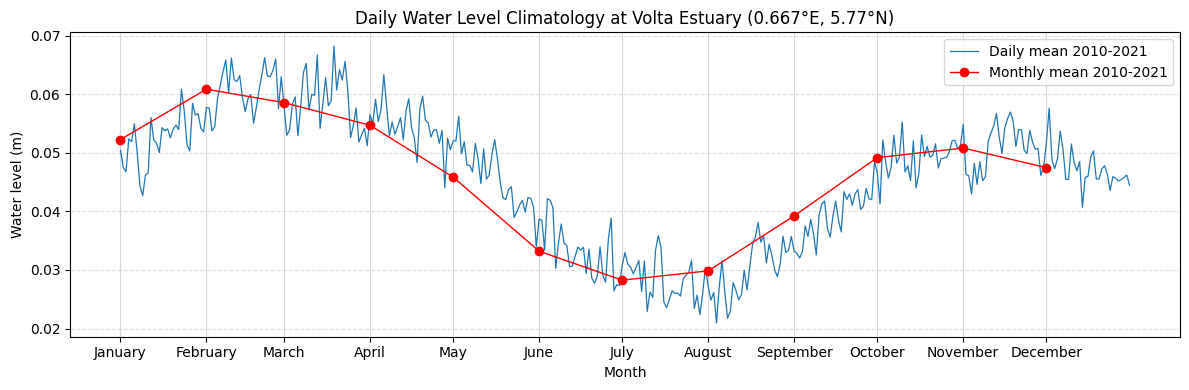

In [ ]:
# Plots
months = list(calendar.month_name)[1:]
# reference year (already non-leap)
year = pd.to_datetime(wl_dailyclim['date'].values[0]).year
# dates for the monthly (start the month in the same year as daily)
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")

# --------------------------------------
# Daily and monthly climatology plot WL
# --------------------------------------
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(wl_dailyclim['date'].values, wl_dailyclim.values,  
        ms=2, lw=0.9, label = 'Daily mean 2010-2021')
ax.plot(month_dates, wl_clim.values, marker='o', 
         lw=1, color= 'r', label = 'Monthly mean 2010-2021')
ax.set_title("Daily Water Level Climatology at Volta Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Water level (m)")
ax.set_xlabel("Month")
ax.grid(True, axis='x', alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend()

month = pd.date_range('2010-01-01', '2011-01-01', freq='MS')[:-1]
ax.set_xticks(month)
ax.set_xticklabels(months)
ax.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

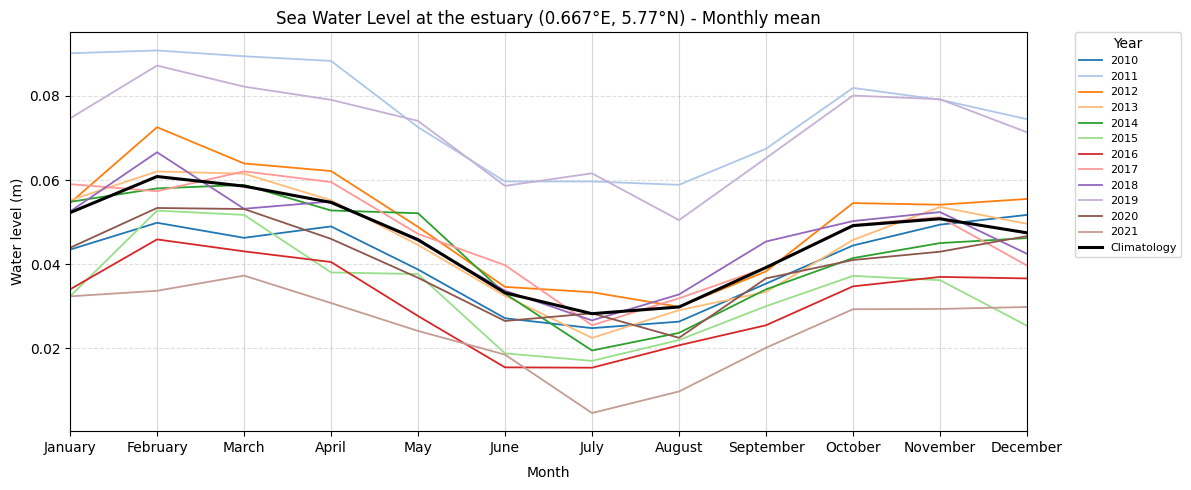

In [ ]:
years = sorted(set(rd_estuary['time'].dt.year.values))

# --------------------------------------
# Monthly mean water level
# --------------------------------------

fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)
cmap = plt.get_cmap('tab20')
colors = [cmap(i % cmap.N) for i in range(len(years))]

for i, (y1, yy1) in enumerate(wl_mon.groupby('time.year')):
    # yy is the monthly series for that year (up to 12 points)
    ax1.plot(yy1['time.month'].values, yy1.values, label=str(y1), lw=1.3, color=colors[i])

ax1.plot(wl_clim['month'], wl_clim.values, color='black', label='Climatology', linewidth=2.2)
ax1.set_title("Sea Water Level at the estuary (0.667°E, 5.77°N) - Monthly mean")
ax1.set_ylabel("Water level (m)")
ax1.set_xlabel("Month", labelpad=8)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.set_xlim(1, 12)
ax1.set_axisbelow(True)
ax1.grid(True, axis='x', which='major', alpha=0.5)             
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=8, ncol=1, title="Year")

plt.tight_layout()
plt.show()

### WL anomaly
#### Anomaly without detrending

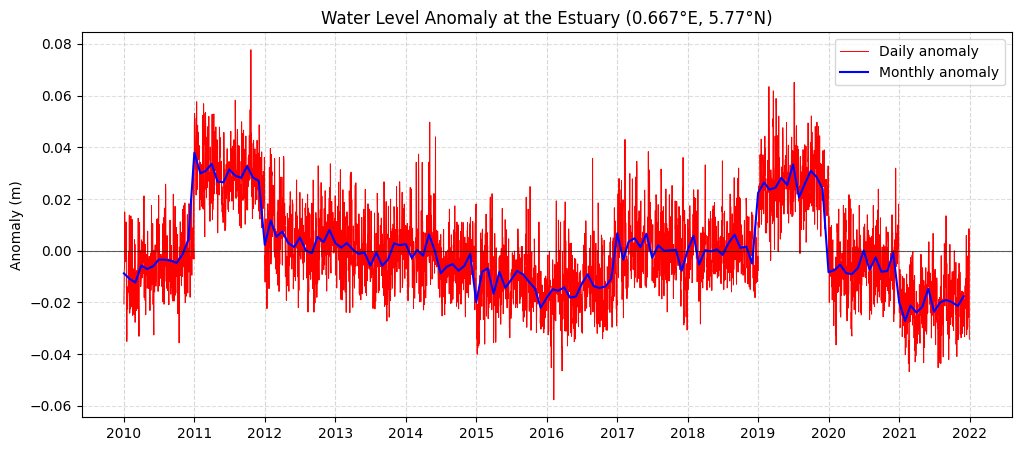

In [ ]:
# get unique years from anomalies
years = np.unique(wl_anom['time.year'].values)

# add one extra year so the grid reaches the end of the plot
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

# --------------------------------------
# Monthly and daily water level anomaly
# --------------------------------------

fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)

# --- Estuary ---
ax1.plot(wl_dailyanom['date'].values, wl_dailyanom.values, linewidth=0.7, color= 'r', label = 'Daily anomaly')
ax1.plot(wl_anom['time'], wl_anom.values, color='blue', linewidth=1.5, label = 'Monthly anomaly')
ax1.axhline(0, color='k', linewidth=0.8, alpha=0.6)  # baseline
ax1.set_title("Water Level Anomaly at the Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Anomaly (m)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)  # show all year numbers including the last
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend()

plt.show()


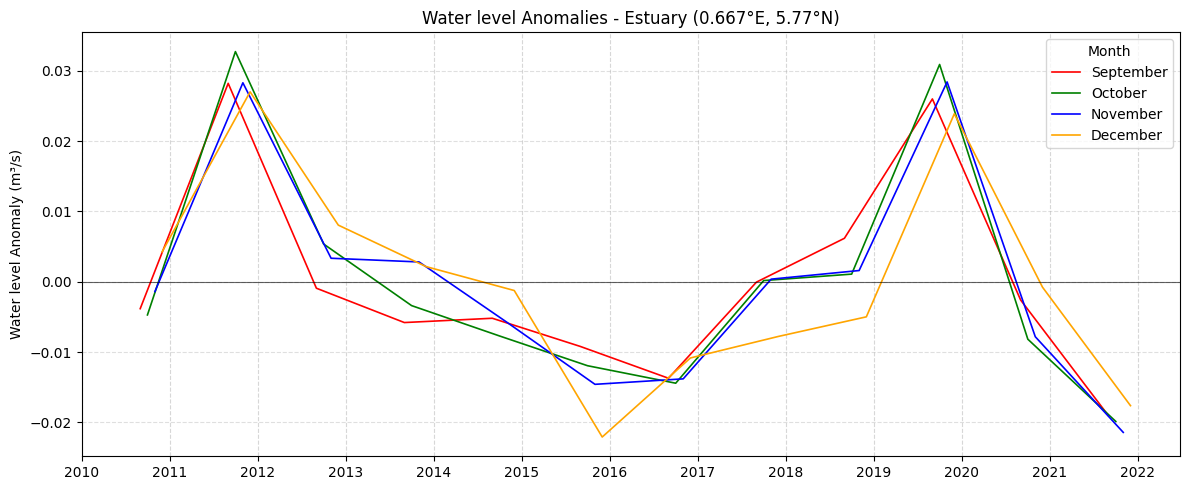

In [ ]:
sel_months = [9, 10, 11, 12]  # mesi che vuoi plottare
colors = ["r", "g", "b", "orange"]  # una lista di colori

fig, ax1 = plt.subplots(figsize=(12, 5), sharex=True)

# --- Estuary ---
for i, m in enumerate(sel_months):
    dataE = wl_anom.sel(time=wl_anom['time.month'] == m)
    ax1.plot(dataE['time'], dataE, color=colors[i], lw=1.2, label=months[m-1])
ax1.axhline(0, color="k", lw=0.8, alpha=0.6)
ax1.set_title("Water level Anomalies - Estuary (0.667°E, 5.77°N)")
ax1.set_ylabel("Water level Anomaly (m³/s)")
ax1.set_xticks(year_ticks)
ax1.set_xticklabels(years_ext)
ax1.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax1.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax1.legend(title="Month")

plt.tight_layout()
plt.show()

This figure compares discharge anomalies at the estuary (top) and Volta Lake (bottom) for isolated months, particularly for September to December between 2010 and 2021. At the estuary, anomalies are very large and highly variable, especially in September and October, with extreme positive events around 2019–2020 and deep negative values in earlier years. November shows moderate variability, while December is generally stable near zero, indicating a more predictable regime at the end of the year. At Volta Lake, anomalies are much smaller, reflecting the buffering effect of the reservoir. Here too September and October show the strongest fluctuations, while November and December remain close to zero, likely due to regulated outflows and the damping effect of storage. Overall, the estuary responds sharply to interannual changes, while the lake smooths them, highlighting the contrast between a free-flowing outlet and a regulated reservoir system.

#### Detrended anomaly
To better understand the variability of a certain climatic index, it is convenient to remove the seasonal cycle from the timeseries by computing the anomaly as the difference between the monthly mean and the long-term monthly mean (the climatology) for each month. In this way we obtain a timesereis of anomaly values that oscillate around the zero (between ...), and that better represent the variability of river discharge in the Keta basin, in Ghana, within the period 2010-2021.

In [ ]:
# --------------------------------------
# Detrended climatologies and anomalies
# --------------------------------------
baseline = ('2010-01-01','2021-12-31')

# helper per assegnare una coord 'date' da cftime -> datetime64
def to_datetime64_from_cftime(tcoord):
    import pandas as pd
    return pd.to_datetime([f"{t.year:04d}-{t.month:02d}-{t.day:02d}" for t in tcoord.values])

# trend and detrended time series
wl_danom_from_anomd, wl_clim_from_anomd, wl_trend = anomd(wl_estuary, baseline=baseline, deg=1)
wl_detr = wl_estuary - wl_trend.interp(time=wl_estuary['time'])

# detrended monthly climatology
wl_dclim_m = wl_detr.sel(time=slice(*baseline)).groupby('time.month').mean('time')

# detrended daily climatology
is_feb29_w = (wl_detr.time.dt.month == 2) & (wl_detr.time.dt.day == 29)
wl_detr_noleap = wl_detr.sel(time=~is_feb29_E).convert_calendar("noleap", dim="time", align_on="date")
wl_dclim_d = wl_detr_noleap.sel(time=slice(*baseline)).groupby('time.dayofyear').mean('time')

dates_clim_w = pd.date_range("2010-01-01", periods=int(wl_dclim_d.sizes["dayofyear"]), freq="D")
wl_dclim_d = wl_dclim_d.assign_coords(date=("dayofyear", dates_clim_w))

# detrended anomalies
wl_danom_d = wl_detr_noleap.groupby('time.dayofyear') - wl_dclim_d
wl_danom_d = wl_danom_d.assign_coords(date=("time", to_datetime64_from_cftime(wl_danom_d["time"])))

wl_danom_m = wl_detr.resample(time='MS').mean().groupby('time.month') - wl_dclim_m

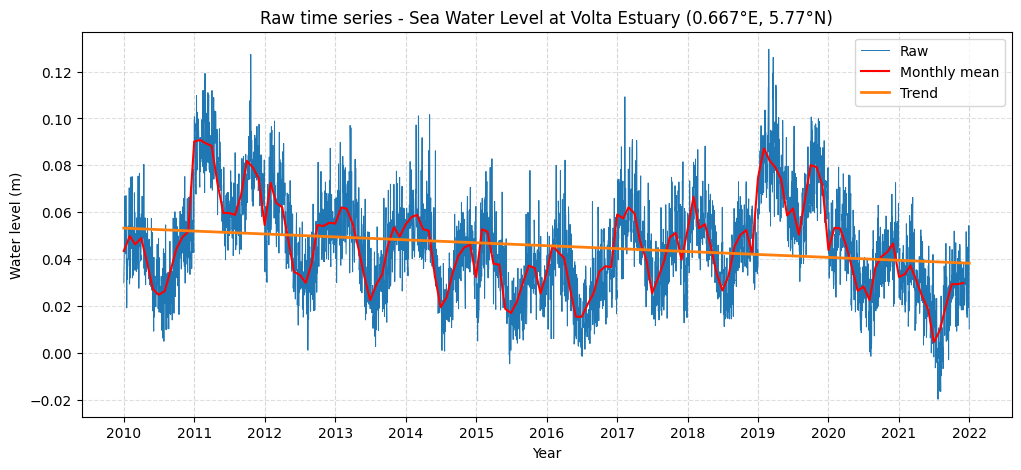

In [ ]:
#--------------------------------------
# Timeseries of Water Level with trend
#--------------------------------------
# Plot
fig, ax = plt.subplots(figsize=(12, 5), sharex=True)
ax.plot(wl_estuary.time, wl_estuary, linestyle='-', lw = 0.7, label = 'Raw')
ax.plot(wl_mon.time, wl_mon, linestyle = '-', color = 'r', label = 'Monthly mean')
ax.plot(wl_trend['time'], wl_trend, linewidth=2, label="Trend", color="tab:orange")
ax.set_title("Raw time series - Sea Water Level at Volta Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Water level (m)")  
ax.set_xlabel("Year")
ax.grid(True)
# vertical lines: one per month
ax.grid(True, axis='x', which='major', alpha=0.5)
# a few horizontal lines (major only)
ax.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax.legend()

# one vertical grid line per year
year_loc = mdates.YearLocator()              # every year
year_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(year_loc)
ax.xaxis.set_major_formatter(year_fmt)
ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)

plt.show()

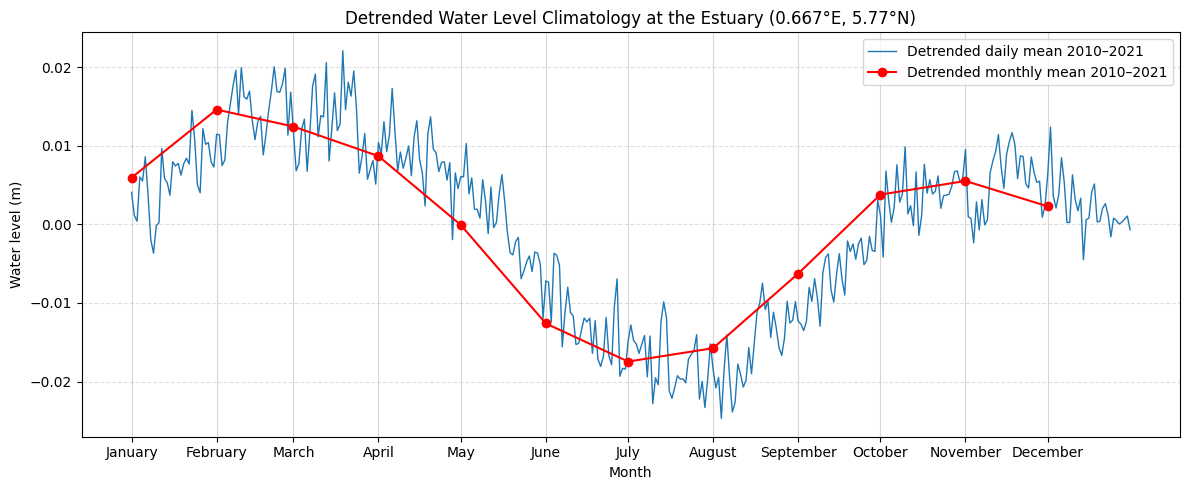

In [ ]:
# -----------------------------------------------
# Daily vs Monthly detrended climatology plot
# -----------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5), sharex=True)

# reference year (already non-leap)
year = pd.to_datetime(wl_dclim_d['date'].values[0]).year
month_dates = pd.date_range(f"{year}-01-01", periods=12, freq="MS")

ax.plot(wl_dclim_d['date'].values, wl_dclim_d.values, lw=1, label="Detrended daily mean 2010–2021")
ax.plot(month_dates, wl_dclim_m.values, marker='o', color= 'r', label="Detrended monthly mean 2010–2021")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.set_title("Detrended Water Level Climatology at the Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Water level (m)")
ax.set_xlabel("Month")
month = pd.date_range('2010-01-01', '2011-01-01', freq='MS')[:-1]
ax.set_xticks(month)
ax.set_xticklabels(months)
ax.grid(True, axis='x', alpha=0.5)
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
ax.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()


In [ ]:
wl_dclim_d.idxmin()

<xarray.DataArray 'dayofyear' ()> Size: 8B
array(216.)

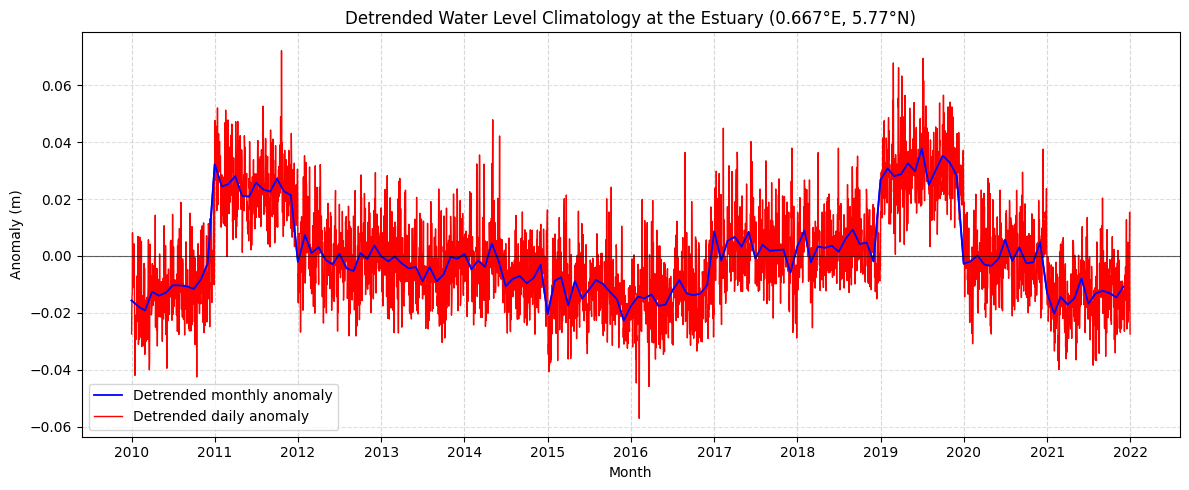

In [ ]:
# ----------------------------------------
# Daily vs Monthly detrended anomaly plot 
# ----------------------------------------
# Unique years + one extra for right edge
years = np.unique(rdE_danom_d['time.year'].values)
years_ext = np.append(years, years[-1] + 1)
year_ticks = [np.datetime64(f"{y}-01-01") for y in years_ext]

fig, ax = plt.subplots(figsize=(12, 5), sharex=True)

ax.plot(wl_danom_m['time'].values, wl_danom_m.values, lw=1.3, color = 'b', label="Detrended monthly anomaly")
ax.plot(wl_danom_d['time'].values, wl_danom_d.values, lw = 1, color = 'r', label="Detrended daily anomaly")
ax.plot(wl_danom_m['time'].values, wl_danom_m.values, lw=1.3, color = 'b')
ax.axhline(0, color='k', linewidth=0.8, alpha=0.6)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.set_title("Detrended Water Level Climatology at the Estuary (0.667°E, 5.77°N)")
ax.set_ylabel("Anomaly (m)")
ax.set_xlabel("Month")
ax.set_xticks(year_ticks)
ax.set_xticklabels(years_ext)
ax.grid(True, axis='x', which='major', linestyle='--', alpha=0.5)
ax.grid(True, axis='y', which='major', linestyle='--', alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
wl_danom_m.min()

<xarray.DataArray ()> Size: 8B
array(-0.0227064)

# Power Spectrum
To understand which are the dominant frequencies of the signal, it is performed a power spectrum analysis. The power spectrum is a representation of a certain signal (here the River Discharge and Water Level) in the frequency domain. In fact, it is taken the lenght of the timeseries and considered as the sum of 12 periods of one year. The power spectrum is then estimated by calculating the Fast Fourier Transform for the time series and by taking the absolute value of the normalized spectrum.

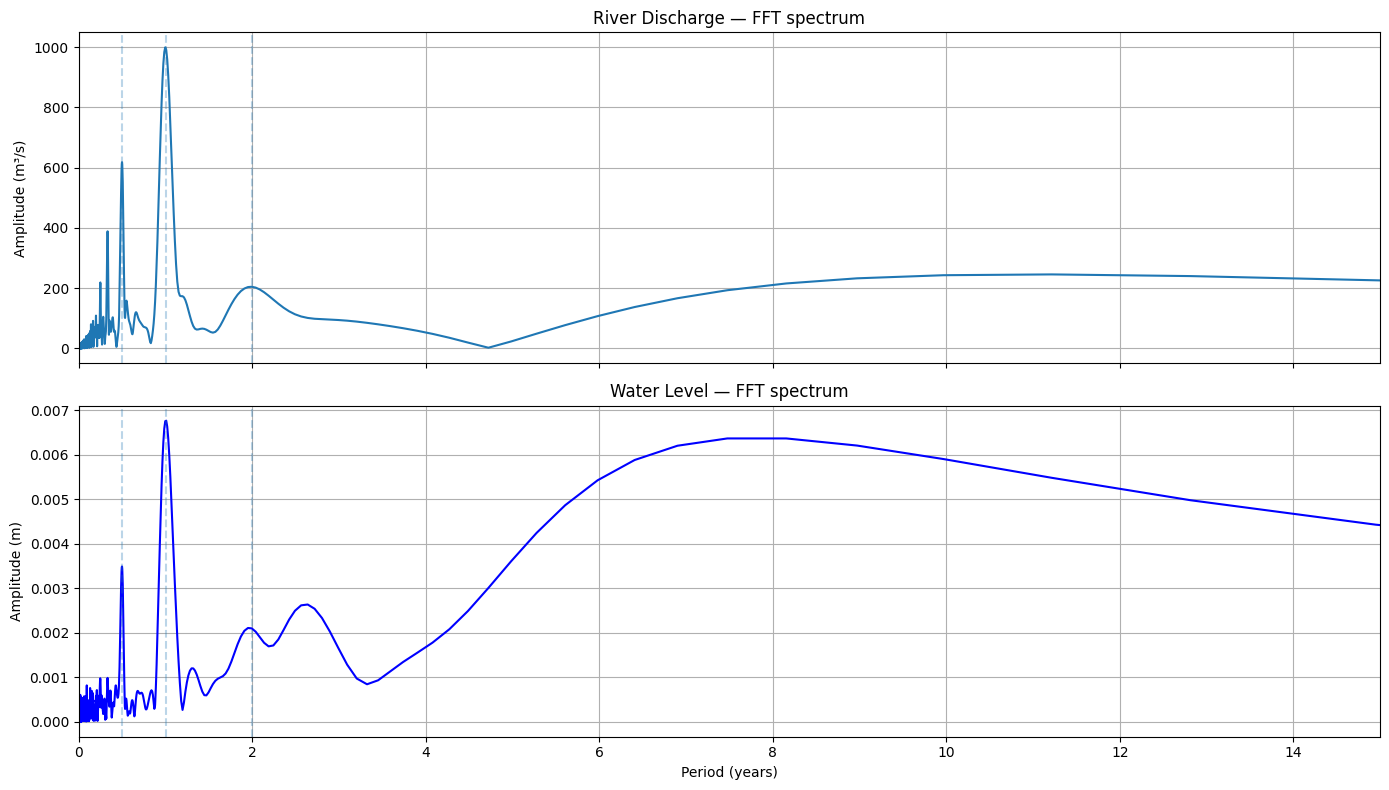

In [ ]:
def fft_spectrum_xr(da: xr.DataArray, pad_factor=4, window='hann'):
    """
    One-sided FFT spectrum for a 1D DataArray with a 'time' coord.
    Returns period (years), amplitude (units), PSD (units^2 / cycles·yr^-1).
    """
    da = da.dropna('time')
    x = da.values.astype(float)
    t = da['time'].values

    # samples per year from median step
    dt_days = np.median(np.diff(t).astype('timedelta64[D]').astype(float))
    fs = 365.2425 / dt_days  # samples/year (≈12 for monthly, ≈365 for daily)

    # de-mean + window
    N = len(x)
    x = x - np.mean(x)
    w = np.hanning(N) if window == 'hann' else np.ones(N)
    U = (w**2).mean()

    # zero-padding for a finer grid
    Nfft = 2**int(np.ceil(np.log2(pad_factor*N)))
    X = np.fft.rfft(x * w, n=Nfft)
    f = np.fft.rfftfreq(Nfft, d=1/fs)          # cycles/year

    # one-sided amplitude and PSD (Parseval-consistent)
    A = 2*np.abs(X)/N
    P = (np.abs(X)**2) / (fs * N * U)
    if N > 1:
        P[1:-1] *= 2.0

    m = f > 0
    period = 1.0 / f[m]
    return period, A[m], P[m]

# ----- compute -----
per_rd, A_rd, PSD_rd = fft_spectrum_xr(rd_estuary)
per_wl, A_wl, PSD_wl = fft_spectrum_xr(wl_estuary)

# ----- plot (amplitude; swap A_* -> PSD_* and change ylabel if you prefer PSD) -----
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(per_rd, A_rd, '-', label='RD FFT')
ax1.set_ylabel('Amplitude (m³/s)')
ax1.set_title('River Discharge — FFT spectrum'); ax1.grid(True)

ax2.plot(per_wl, A_wl, '-', color='b', label='WL FFT')
ax2.set_xlabel('Period (years)')
ax2.set_ylabel('Amplitude (m)')
ax2.set_title('Water Level — FFT spectrum'); ax2.grid(True)

# helpful guides
for ax in (ax1, ax2):
    ax.set_xlim(0, 15)                     # focus on <= 10 years (adjust if needed)
    for T in (0.5, 1, 2): ax.axvline(T, ls='--', alpha=0.3)

plt.tight_layout(); plt.show()


A power spectrum shows how the variance of a time series is distributed across frequencies. Peaks indicate periodic components: a narrow, tall peak means a strong, nearly periodic oscillation at that frequency; broad, low power means more random, broadband variability. Spectra are useful because they reveal dominant cycles (e.g. seasonal or semi-annual), help compare variability across time-scales, and guide filtering or modeling. Both RD and WL display a dominant peak at about 1 year, confirming a strong seasonal cycle. RD shows a noticeable secondary peak near 0.5 year (semi-annual modulation), likely tied to hydrological sub-seasonal forcing; that line is much weaker in WL, consistent with water level being dynamically smoothed relative to discharge. RD also has more high-frequency energy (short periods < ~0.5–1 yr), reflecting sharper, event-driven variability. WL amplitudes are much smaller (mm–cm scale), as expected, and its spectrum tilts a bit toward longer periods, consistent with storage/backwater effects that integrate and damp fast changes.

# PDF analysis
The probability distribution function is a mathematical function that describes the relative likelihood of observing a particular variable within a range of values: by fitting observed data to different probability distributions, it is possible to identify the distribution that provides the best fit and describe the variability of the variable under study. Furthermore, by analyzing the tails of the distribution, it is possible to determine the likelihood of extreme events occurring, estimate return periods, and evaluate the severity and intensity of such events.

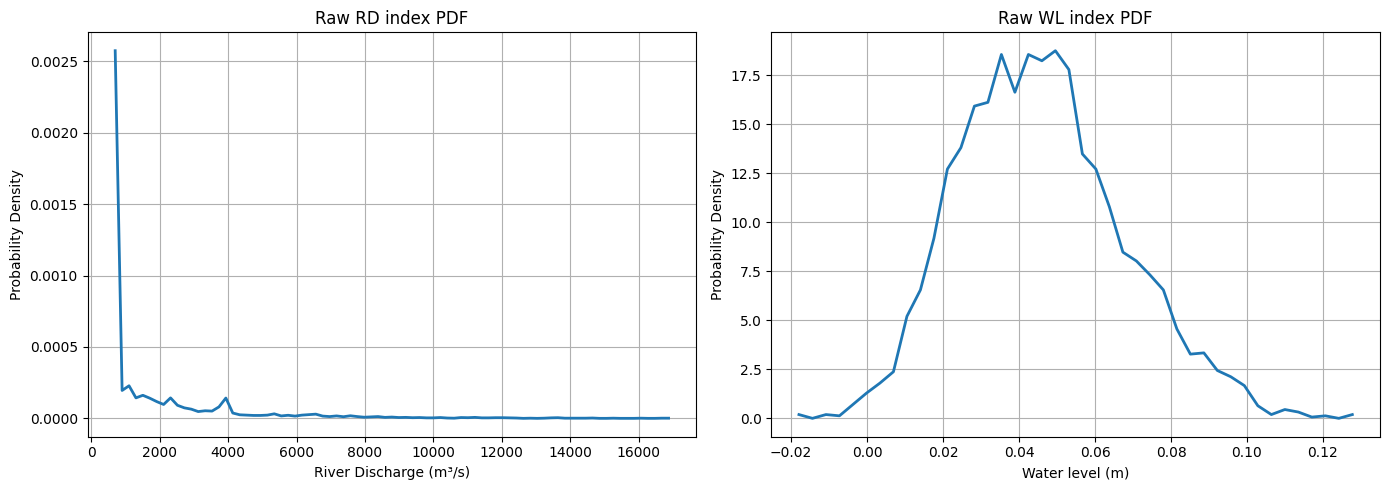

In [ ]:
# Compute and plot the histograms to see the PDF of the rd and wl raw indeces
rdv = rd.dropna().to_numpy()
wlv = wl.dropna().to_numpy()

# Define the bins for RD and WL raw indeces
bins_rd = np.histogram_bin_edges(rdv, bins='fd')  # Freedman–Diaconis
bins_wl = np.histogram_bin_edges(wlv, bins='fd')

# Compute the histograms
hist_rd, edges_rd = np.histogram(rdv, bins=bins_rd, density=True)
hist_wl, edges_wl = np.histogram(wlv, bins=bins_wl, density=True)

# Calculate the bin centers
cent_rd = (edges_rd[:-1] + edges_rd[1:]) / 2
cent_wl = (edges_wl[:-1] + edges_wl[1:]) / 2

# Plotting the PDFs
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(cent_rd, hist_rd, lw=2)
ax[0].set(title='Raw RD index PDF', ylabel='Probability Density', xlabel='River Discharge (m³/s)')
ax[0].grid(True)

ax[1].plot(cent_wl, hist_wl, lw=2)
ax[1].set(title='Raw WL index PDF', ylabel='Probability Density', xlabel='Water level (m)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

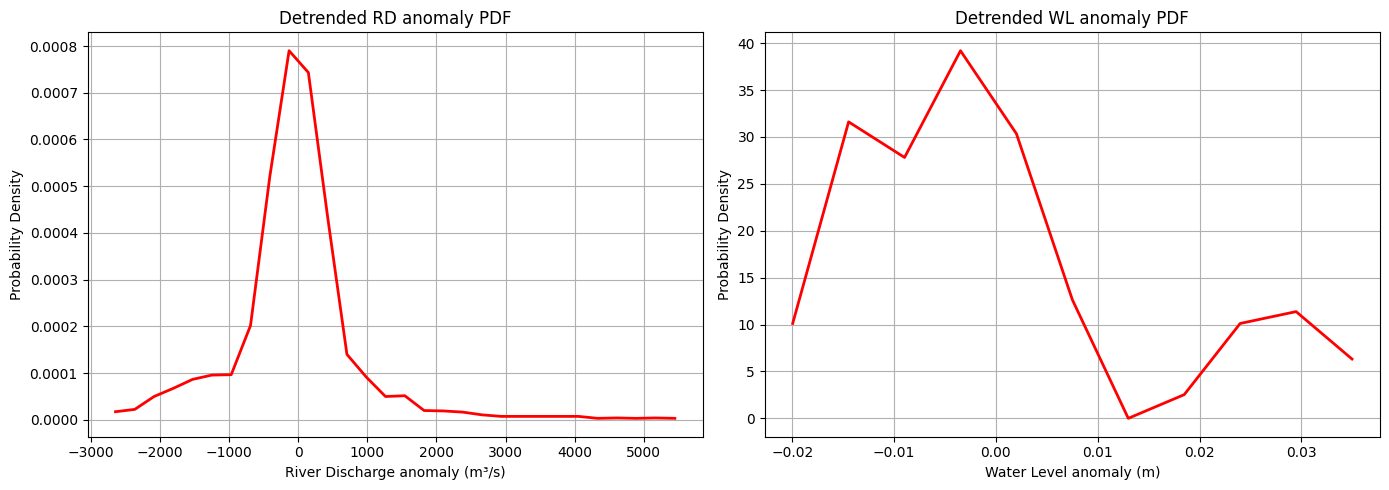

In [ ]:
# Compute and plot the histograms to see the PDF of the rd and wl detrended anomalies
# DataArray -> NumPy 1D without NaN
rddv = rdE_danom_m.to_series().dropna().to_numpy()
wldv = wl_danom_m.to_series().dropna().to_numpy()

# Define the bins for RD and WL detrended anomalies, limiting the outliers.
rddv_bins_base = np.clip(rddv, np.percentile(rddv, 1), np.percentile(rddv, 99))
bins_rdd = np.histogram_bin_edges(rddv_bins_base, bins=30)   # 30 bin regolari
bins_wld = np.histogram_bin_edges(wldv, bins='fd')           # FD va bene per WL

# Compute the histograms
hist_rdd, edges_rdd = np.histogram(rddv, bins=bins_rdd, density=True)
hist_wld, edges_wld = np.histogram(wldv, bins=bins_wld, density=True)

# Calculate the bin centers
cent_rdd = (edges_rdd[:-1] + edges_rdd[1:]) / 2
cent_wld = (edges_wld[:-1] + edges_wld[1:]) / 2

# Plotting the PDFs
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(cent_rdd, hist_rdd, lw=2, color='r')
ax[0].set(title='Detrended RD anomaly PDF',
          ylabel='Probability Density',
          xlabel='River Discharge anomaly (m³/s)')
ax[0].grid(True)

ax[1].plot(cent_wld, hist_wld, lw=2, color='r')
ax[1].set(title='Detrended WL anomaly PDF',
          ylabel='Probability Density',
          xlabel='Water Level anomaly (m)')
ax[1].grid(True)

plt.tight_layout()
plt.show()

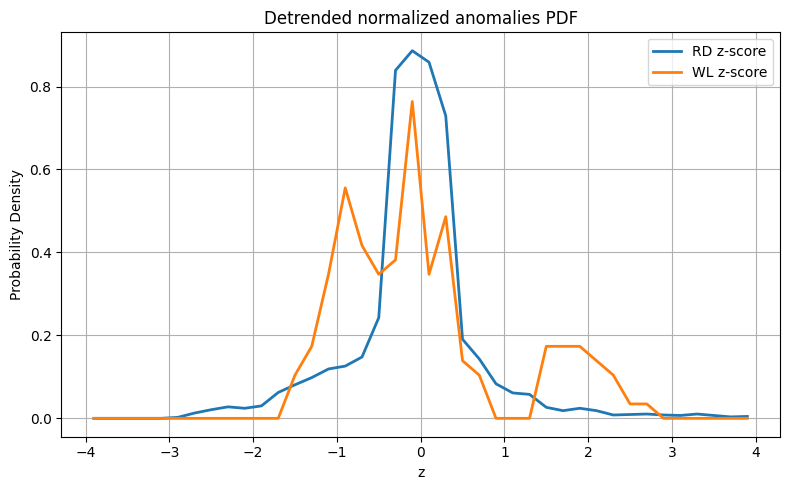

In [ ]:
# To compare shapes fairly, it's opportune to normalize both datasets to z-scores and then plot on the same axis

# DataArray -> NumPy 1D without NaN
rddv = rdE_danom_m.to_series().dropna().to_numpy()
wldv = wl_danom_m.to_series().dropna().to_numpy()

# Normalization
zr = (rddv - rddv.mean()) / rddv.std(ddof=1)
zw = (wldv - wldv.mean()) / wldv.std(ddof=1)

# Computation of bin width, histograms, and bin centers
bins = np.linspace(-4, 4, 41)
hr, e = np.histogram(zr, bins=bins, density=True)
hw, _ = np.histogram(zw, bins=bins, density=True)
c = (e[:-1] + e[1:]) / 2

# Plot of compared normalized PDFs
plt.figure(figsize=(8,5))
plt.plot(c, hr, lw=2, label='RD z-score')
plt.plot(c, hw, lw=2, label='WL z-score')
plt.xlabel('z'); plt.ylabel('Probability Density'); plt.grid(True); plt.legend()
plt.title('Detrended normalized anomalies PDF')
plt.tight_layout(); plt.show()


Both distributions are centered around z ≈ 0, as expected after detrending and standardizing. This confirms that anomalies are properly centered on their mean. The Water Level distribution is fairly concentrated around the mean (–1 < z < +1), with relatively little mass beyond ±2, suggesting that WL anomalies are relatively stable and rarely extreme. While also peaked near z = 0, River Discharge shows more spread into the tails (values up to +3 and down to –2.5), meaning that discharge anomalies are more variable and prone to extreme events than WL. 
The heavier right tail (z > 2) of RD distribution, compared to the ones of WL, reflects a strong response to episodic extremes (e.g., flood-like conditions), while WL tails fall off more quickly, meaning extreme deviations in water level (relative to its detrended mean) are rarer.

## Joint PDF

In [ ]:
def joint_pdf_2d(x, y, n_bins=60, center='median', mode='pdf'):
    """
    Empirical joint distribution on a rectilinear grid centered at mean/median.

    x, y      : 1D arrays (NaNs allowed; they are dropped)
    n_bins    : number of bins per axis (bin width = (max-min)/n_bins)
    center    : 'median' or 'mean' for where the grid is centered
    mode      : 'pdf' (default), 'prob' (probability per bin), or 'count'

    Returns
    -------
    M   : 2D array (shape [nx, ny]) with pdf/probability/counts
    XC  : 2D array of x bin centers (same shape as M)
    YC  : 2D array of y bin centers (same shape as M)
    dx, dy : bin widths (scalars)
    """
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]

    # ranges and widths
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    dx = (xmax - xmin) / n_bins
    dy = (ymax - ymin) / n_bins

    # grid centers (symmetrically around mean/median, like your code)
    cx = np.median(x) if center == 'median' else x.mean()
    cy = np.median(y) if center == 'median' else y.mean()

    x_plus  = np.arange(cx, xmax + dx,  dx)
    x_minus = np.arange(cx, xmin - dx, -dx)[-1:0:-1]
    xc = np.concatenate([x_minus, x_plus])

    y_plus  = np.arange(cy, ymax + dy,  dy)
    y_minus = np.arange(cy, ymin - dy, -dy)[-1:0:-1]
    yc = np.concatenate([y_minus, y_plus])

    # convert centers -> edges for histogram2d
    xedges = np.r_[xc - dx/2, xc[-1] + dx/2]
    yedges = np.r_[yc - dy/2, yc[-1] + dy/2]

    # raw counts per bin
    H, _, _ = np.histogram2d(x, y, bins=[xedges, yedges], density=False)

    if mode == 'count':
        M = H
    elif mode == 'prob':
        M = H / H.sum()                       # Σ M = 1
    else:  # 'pdf'
        M = H / (H.sum() * dx * dy)           # ∫∫ M dx dy = 1

    # centers mesh (same shape as M)
    XC, YC = np.meshgrid(xc, yc, indexing='ij')
    return M, XC, YC, dx, dy


In [ ]:

# align and drop NaNs
danom_aligned = xr.Dataset({'rd': rdE_danom_m, 'wl': wl_danom}).to_dataframe().dropna()
x = danom_aligned['rd'].to_numpy()
y = danom_aligned['wl'].to_numpy()

# joint PDF
P, XX, YY, dx, dy = joint_pdf_2d(x, y, n_bins=40, center='median', mode='pdf')

# plot (PDF)
plt.figure(figsize=(7,6))
cs = plt.contourf(XX, YY, P, levels=20, cmap='jet')
plt.colorbar(cs, label='Probability density')
plt.xlabel('RD anomaly (m³/s)')
plt.ylabel('WL anomaly (m)')
plt.title('Joint PDF RD–WL')
plt.tight_layout()
plt.show()


NameError: name 'wl_danom' is not defined

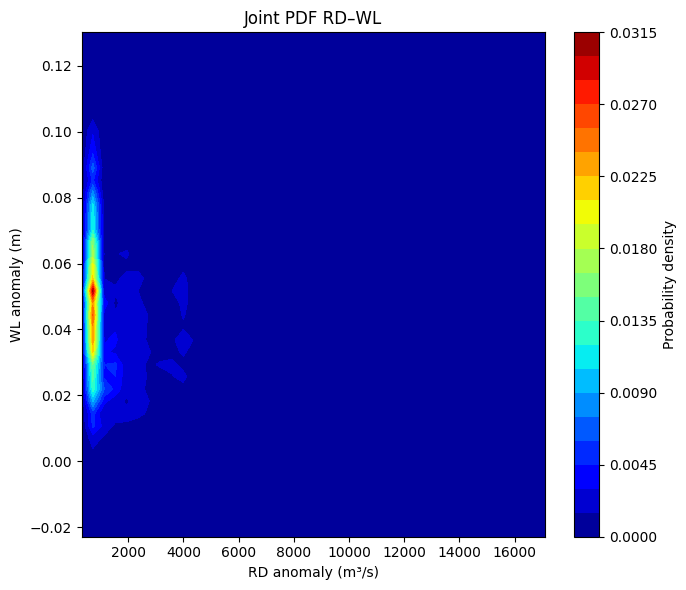

In [ ]:
# align and drop NaNs
aligned = xr.Dataset({'rd': rd_estuary, 'wl': wl_estuary}).to_dataframe().dropna()
x = aligned['rd'].to_numpy()
y = aligned['wl'].to_numpy()

# joint PDF
P, XX, YY, dx, dy = joint_pdf_2d(x, y, n_bins=40, center='median', mode='pdf')

# plot (PDF)
plt.figure(figsize=(7,6))
cs = plt.contourf(XX, YY, P, levels=20, cmap='jet')
plt.colorbar(cs, label='Probability density')
plt.xlabel('RD anomaly (m³/s)')
plt.ylabel('WL anomaly (m)')
plt.title('Joint PDF RD–WL')
plt.tight_layout()
plt.show()


# Definition of indicators: RD - river discharge and WL - water level
In the following section, an indicator-based framework is adopted to identify days and events relevant to compound river–ocean flooding. 

1) For each driver (that is daily river discharge `Q = RD` and offshore meteorological water level `η = WL`) a high **threshold** `u` is defined and two signals are derived: 
    - (i) a binary exceedance indicator `I(t)=1{x(t)≥u}` used to quantify occurrence, and 
    - (ii) the exceedance “intensity” `X(t)=max⁡[0, x(t)−u]` used to characterize severity. 

    This peaks-over-threshold (POT) construction follows standard extreme-value practice and is preferred over annual-maxima approaches because it retains more tail information for inference.

    Because river flow and storm-driven offshore levels exhibit strong seasonality, thresholds are allowed to vary with the calendar month (**“seasonal” thresholds**) so that exceedance rates are closer to stationary through the year and exceedances retain a consistent meaning across seasons. Time-varying or covariate-dependent thresholds are widely recommended in environmental extremes when nonstationarity or seasonality is present.

2) **Compound occurrence** is defined as the temporal co-occurrence of high `RD` and high `WL` within a short window ±k days, thereby accommodating physical lags between catchment response and coastal water-level anomalies. This definition aligns with the typology of temporally compounding events in the compound-events literature and with empirical coastal studies that quantify elevated risk when surge and rainfall/runoff overlap in time. 

3) To convert day-level coincidence into event objects suitable for statistical analysis, exceedance days are **declustered**: consecutive (or near-consecutive) compound days separated by short quiet gaps are merged into single events, from which start/end dates, peak magnitudes and inter-driver peak lags were extracted. Runs-declustering is a standard step in POT analyses to obtain approximately independent clusters before tail modeling and uncertainty assessment.

In [ ]:
# --- 0) Align cleanly (inner join on daily dates) ---
""""Build a single daily index, ensuring both drivers are observed on the same days. 
    This avoids spurious “co-occurrence” caused by missing data and sets up like-for-like 
    comparisons before extremes sampling."""
aligned = (
    pd.DataFrame({"RD": rd, "WL": wl})       # the two Series
      .sort_index()
      .loc["2010-01-01":"2021-12-31"]        # optional crop
      .dropna()                              # keep only days with both values
)
print("Aligned days:", len(aligned), "| period:", aligned.index.min().date(), "→", aligned.index.max().date())

# --- 1) Thresholds (fixed vs seasonal) ---
def thresholds(series, q=0.95, mode="seasonal", baseline=("2010-01-01","2021-12-31")):
    """
    Compute a quantile-based threshold time series aligned to `series.index`.
    ----------
    Parameters
    - series : pandas.Series
        Input daily series.
    - q : float, default 0.95
        Quantile to use as the threshold (0.95 for the 95th percentile).
    - mode : {"seasonal", "fixed"}, default "seasonal"
        - "seasonal": month-varying thresholds computed on the baseline window and mapped to each day by calendar month.
        - "fixed": a single threshold value (same for all days) computed on the baseline window.
    - baseline : (str, str) or None
        Date range ("2010-01-01","2021-12-31") used to compute the thresholds.
        If None, the full series is used.
    ----------
    Returns → th : pandas.Series
                   Threshold series aligned to `series.index`.
    """
    s = series.copy()
    if baseline is not None:
        s_base = s.loc[slice(*baseline)]
    else:
        s_base = s

    if mode == "seasonal":
        # month → threshold lookup (1..12)
        mon_th = s_base.groupby(s_base.index.month).quantile(q)
        th = s.index.month.map(mon_th.to_dict()).astype(float)
        th = pd.Series(th, index=s.index)
    elif mode == "fixed":
        th_val = float(s_base.quantile(q))
        th = pd.Series(th_val, index=s.index)
    else:
        raise ValueError("mode must be 'seasonal' or 'fixed'")
    return th

def indicators(series, q=0.95, mode="seasonal", baseline=("2010-01-01","2021-12-31")):
    """
    Construct exceedance indicators for an input Series.
    For each day in the series, a high quantile threshold `th` is computed from a specified baseline period and aligned to the index. 
      - If mode='fixed', `th` is the same scalar threshold for all months. 
      - If mode='seasonal', `th` varies by calendar month to account for seasonality.

    The function returns three Series, all aligned to the input index:
      1) `th`    – the threshold values,
      2) `flag`  – a binary indicator (1 if series ≥ th, else 0),
      3) `excess`– the exceedance intensity (series − th, truncated below at 0).
    """
    th = thresholds(series, q=q, mode=mode, baseline=baseline)
    flag = (series >= th).astype("int8")
    excess = (series - th).clip(lower=0.0)
    return th, flag, excess

# build for both drivers
thRD, Ird, Xrd   = indicators(aligned["RD"],   q=0.95, mode="seasonal")
thWL, Iwl, Xwl   = indicators(aligned["WL"], q=0.95, mode="seasonal")

# --- 2) Compound coincidence within ±k days ---
def compound_flag(Ird, Iwl, k=1):
    """ Compute a compound day when RD and WL exceedances co-occur within ± k days, by rolling-window “dilation” of each flag and coincidence. 

    For each day t, the function returns 1 if an RD exceedance occurs within ±k days of t and a WL exceedance occurs within ±k days of t; 
    otherwise 0. Operationally, each binary exceedance series is dilated with a centered window of width 2k+1 (rolling max), and
    the intersection (logical AND) of the dilated series is taken.

    Notes
    • This symmetric definition marks the overlap day(s) of the two ±k neighborhoods; when
      peaks are lagged, the compound flag can fall between the two peak days.
    • To anchor the definition on RD days instead (tag an RD exceedance day as compound if
      any WL exceedance occurs within ±k), replace the final AND with:
          (Ird.astype(bool) & (Iwl.rolling(2*k+1, center=True, min_periods=1).max() > 0))
    • Inputs should be clean 0/1 (or bool) without NaNs; fill missing values with 0 if needed.
    """
    win = 2*k + 1
    Ird_d = Ird.rolling(win, center=True, min_periods=1).max()
    Iwl_d = Iwl.rolling(win, center=True, min_periods=1).max()
    return (Ird_d.astype(bool) & (Iwl_d > 0)).astype("int8")

COMP = compound_flag(Ird, Iwl, k=1)

# --- 3) Decluster consecutive (or near-consecutive) compound days into events ---
def decluster_runs(flag, run=3):
    """
    Identify clusters of consecutive exceedance days in a binary series.

    Consecutive 1s in `flag` (Series of 0/1) are merged into runs, and runs
    separated by gaps of at most `run` days are also merged into a single
    cluster. This implements the standard runs-declustering approach used in
    peaks-over-threshold analyses to obtain approximately independent events.
    """
    s = flag.fillna(0).astype(int).values
    n = len(s)
    events = []
    i = 0
    while i < n:
        if s[i] == 1:
            start = i
            last = i
            j = i
            while j+1 < n and ((s[j+1] == 1) or (j+1 - last) <= run):
                if s[j+1] == 1:
                    last = j+1
                j += 1
            events.append((start, last))
            i = last + 1
        else:
            i += 1
    return events

def build_event_table(aligned, Ird, Iwl, Xrd, Xwl, COMP, run=3):
    """
    Summarize declustered compound events.
    """
    t = aligned.index
    idx_windows = decluster_runs(COMP, run=run)
    rows = []
    for i0, i1 in idx_windows:
        sl = slice(i0, i1+1)
        tt = t[sl]

        rd_w  = aligned["RD"].iloc[sl]
        wl_w  = aligned["WL"].iloc[sl]
        xRD_w = Xrd.iloc[sl]
        xWL_w = Xwl.iloc[sl]
        iRD_w = Ird.iloc[sl]
        iWL_w = Iwl.iloc[sl]

        rd_peak_val = rd_w.max();  rd_peak_time = rd_w.idxmax()
        wl_peak_val = wl_w.max();  wl_peak_time = wl_w.idxmax()
        lag_days = (wl_peak_time - rd_peak_time).days

        sev_rd  = xRD_w.sum()
        sev_wl  = xWL_w.sum()
        sev_L2 = np.hypot(sev_rd, sev_wl)

        rows.append(dict(
            start = tt[0], end=tt[-1], duration=(tt[-1]-tt[0]).days+1,
            rd_peak = rd_peak_val, rd_peak_time = rd_peak_time,
            wl_peak = wl_peak_val, wl_peak_time = wl_peak_time,
            lag_wl_minus_rd_days = lag_days,
            sev_rd = sev_rd, sev_wl = sev_wl, sev_L2=sev_L2,
            n_rd_exceed=int(iRD_w.sum()), n_wl_exceed=int(iWL_w.sum())
        ))
    return pd.DataFrame(rows).sort_values("start").reset_index(drop=True)

events = build_event_table(aligned, Ird, Iwl, Xrd, Xwl, COMP, run=3)

print("Compound events:", len(events))
print(events.head())


Aligned days: 4383 | period: 2010-01-01 → 2021-12-31
Compound events: 8
       start        end  duration     rd_peak rd_peak_time  wl_peak  \
0 2010-12-31 2011-01-04         5   730.65625   2010-12-31   0.1007   
1 2011-02-27 2011-03-06         8   636.59375   2011-03-02   0.1164   
2 2016-08-26 2016-08-27         2  3492.43750   2016-08-27   0.0646   
3 2019-02-04 2019-02-08         5   624.53125   2019-02-04   0.1035   
4 2019-02-26 2019-02-27         2   620.43750   2019-02-27   0.1295   

  wl_peak_time  lag_wl_minus_rd_days      sev_rd   sev_wl      sev_L2  \
0   2011-01-02                     2  132.060156  0.03068  132.060160   
1   2011-02-28                    -2   38.293750  0.04028   38.293771   
2   2016-08-26                    -1  135.958594  0.00282  135.958594   
3   2019-02-05                     1   12.015625  0.01718   12.015637   
4   2019-02-26                    -1    0.496875  0.03459    0.498078   

   n_rd_exceed  n_wl_exceed  
0            3            4  
1 

In [ ]:
def events_table(events: pd.DataFrame) -> pd.DataFrame:
    tbl = events.copy()
    tbl.insert(0, "event_id", range(1, len(tbl)+1))
    tbl = tbl.rename(columns={
        "start":"start_date", "end":"end_date",
        "duration":"duration_days",
        "rd_peak":"RD_peak", "rd_peak_time":"RD_peak_time",
        "wl_peak":"WL_peak", "wl_peak_time":"WL_peak_time",
        "lag_wl_minus_rd_days":"lag_WL_minus_RD_days",
        "sev_rd":"sev_RD", "sev_wl":"sev_WL", "sev_L2":"sev_L2",
        "n_rd_exceed":"n_RD_exceed", "n_wl_exceed":"n_WL_exceed"
    })
    # round
    for c in ["RD_peak","WL_peak","sev_RD","sev_WL","sev_L2"]:
        tbl[c] = tbl[c].astype(float).round(3)
    return tbl

tbl = events_table(events)
display(tbl)
tbl.to_csv("compound_events.csv", index=False)


event_id start_date   end_date  duration_days    RD_peak RD_peak_time  \
0         1 2010-12-31 2011-01-04              5    730.656   2010-12-31   
1         2 2011-02-27 2011-03-06              8    636.594   2011-03-02   
2         3 2016-08-26 2016-08-27              2   3492.438   2016-08-27   
3         4 2019-02-04 2019-02-08              5    624.531   2019-02-04   
4         5 2019-02-26 2019-02-27              2    620.438   2019-02-27   
5         6 2019-10-13 2019-11-15             34  13975.094   2019-10-25   
6         7 2019-12-02 2019-12-12             11   3102.453   2019-12-02   
7         8 2019-12-31 2019-12-31              1   1009.172   2019-12-31   

   WL_peak WL_peak_time  lag_WL_minus_RD_days     sev_RD  sev_WL     sev_L2  \
0    0.101   2011-01-02                     2    132.060   0.031    132.060   
1    0.116   2011-02-28                    -2     38.294   0.040     38.294   
2    0.065   2016-08-26                    -1    135.959   0.003    135.959   
3    0.104   2019-02-05                     1     12.016   0.017     12.016   
4    0.130   2019-02-26                    -1      0.497   0.035      0.498   
5    0.100   2019-11-10                    16  42596.392   0.085  42596.392   
6    0.091   2019-12-10                     8   6717.114   0.027   6717.114   
7    0.064   2019-12-31                     0      0.000   0.000      0.000   

   n_RD_exceed  n_WL_exceed  
0            3            4  
1            6            4  
2            1            1  
3            5            2  
4            1            1  
5           27           13  
6           11            5  
7            0            0

## Sensitivity grid (q, k, run) — counts & lag summary

In [ ]:
def run_once(q=0.95, k=1, run=3, mode="seasonal"):
    thRD_i, Ird_i, Xrd_i = indicators(aligned["RD"], q=q, mode=mode)
    thWL_i, Iwl_i, Xwl_i = indicators(aligned["WL"], q=q, mode=mode)
    COMP_i = compound_flag(Ird_i, Iwl_i, k=k)
    ev_i   = build_event_table(aligned, Ird_i, Iwl_i, Xrd_i, Xwl_i, COMP_i, run=run)
    lag_median = ev_i['lag_wl_minus_rd_days'].median() if len(ev_i) else float('nan')
    return dict(q=q, k=k, run=run, n_events=len(ev_i), lag_median=lag_median)

grid = []
for q in (0.95, 0.98, 0.99):
    for k in (0, 1, 2):
        for run in (3, 5, 7):
            grid.append(run_once(q=q, k=k, run=run))
sens = pd.DataFrame(grid).sort_values(['q','k','run']).reset_index(drop=True)
sens.head(10)


q  k  run  n_events  lag_median
0  0.95  0    3         7         1.0
1  0.95  0    5         6         0.5
2  0.95  0    7         5         1.0
3  0.95  1    3         8         0.5
4  0.95  1    5         8         0.5
5  0.95  1    7         8         0.5
6  0.95  2    3        12         0.5
7  0.95  2    5        12         0.5
8  0.95  2    7        12         0.5
9  0.98  0    3         4         0.0

## Univariate POT–GPD for RD and WL using your exceedances

In [ ]:
from scipy.stats import genpareto

N_per_year = 365.2425
p_u_RD = Ird.mean()   # exceedance rate per observation (daily)
p_u_WL = Iwl.mean()

# positive exceedances (over your time-varying seasonal thresholds)
exc_RD = Xrd[Xrd > 0].values
exc_WL = Xwl[Xwl > 0].values

# fit GPD with location fixed at 0 (standard POT)
c_RD, loc_RD, s_RD = genpareto.fit(exc_RD, floc=0)
c_WL, loc_WL, s_WL = genpareto.fit(exc_WL, floc=0)

def excess_return_level(T_years, c, s, p_u):
    """Return the exceedance amount z_T above the threshold (scalar), for a T-year return period."""
    # expected exceedances in T years: m = T * N_per_year * p_u
    m = T_years * N_per_year * p_u
    if c != 0:
        return s/c * (m**c - 1)
    else:
        return s * np.log(m)

# Example: 2- and 5-year return **excess** (above threshold)
z2_RD = excess_return_level(2, c_RD, s_RD, p_u_RD)
z5_RD = excess_return_level(5, c_RD, s_RD, p_u_RD)

z2_WL = excess_return_level(2, c_WL, s_WL, p_u_WL)
z5_WL = excess_return_level(5, c_WL, s_WL, p_u_WL)

# Turn excess → absolute return levels by adding a representative threshold.
# With seasonal thresholds, report **monthly** return levels:
mon_th_RD = thRD.groupby(thRD.index.month).median()
mon_th_WL = thWL.groupby(thWL.index.month).median()

RL2_RD_month = mon_th_RD + z2_RD   # Series indexed by month (1..12)
RL5_RD_month = mon_th_RD + z5_RD
RL2_WL_month = mon_th_WL + z2_WL
RL5_WL_month = mon_th_WL + z5_WL


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# --- 1) Timeline with RD & WL peaks ---
def plot_timeline(events):
    fig, ax = plt.subplots(figsize=(10, 5))
    y_positions = np.arange(len(events))
    ax.set_yticks(y_positions)
    labels = [f"E{i+1}" for i in range(len(events))]
    ax.set_yticklabels(labels)

    for i, row in events.iterrows():
        ax.hlines(y=y_positions[i], xmin=row["start"], xmax=row["end"], linewidth=6)
        ax.scatter(row["rd_peak_time"], y_positions[i], marker="^", s=64, color="C0", label="RD peak" if i==0 else "")
        ax.scatter(row["wl_peak_time"], y_positions[i], marker="o", s=48, color="C1", label="WL peak" if i==0 else "")

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.set_xlabel("Date")
    ax.set_title("Compound Event Timeline (bars) with RD (▲) and WL (●) peaks")
    ax.grid(True, axis="x", alpha=0.3)
    ax.legend()
    plt.show()


# --- 2) Lag distribution ---
def plot_lag_distribution(events):
    fig, ax = plt.subplots(figsize=(7, 4))
    lag_counts = events["lag_wl_minus_rd_days"].astype(int).value_counts().sort_index()
    ax.bar(lag_counts.index, lag_counts.values, width=0.8)
    ax.set_xlabel("Lag (days): WL peak − RD peak")
    ax.set_ylabel("Number of events")
    ax.set_title("Distribution of peak timing lags")
    ax.grid(True, axis="y", alpha=0.3)
    plt.show()


# --- 3) Joint RD vs WL peaks ---
def plot_joint_intensity(events):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(events["rd_peak"], events["wl_peak"], s=48)
    for i, row in events.iterrows():
        ax.annotate(f"E{i+1}", (row["rd_peak"], row["wl_peak"]),
                    xytext=(3,3), textcoords="offset points", fontsize=8)
    ax.set_xlabel("RD peak (m³/s)")
    ax.set_ylabel("WL peak (m)")
    ax.set_title("Event peak magnitudes: RD vs WL")
    ax.grid(True, alpha=0.3)
    plt.show()


# --- 4) Seasonality of peaks ---
def plot_seasonality(events):
    fig, ax = plt.subplots(figsize=(9, 4.5))
    months = np.arange(1, 13)
    rd_counts = events["rd_peak_time"].dt.month.value_counts().reindex(months, fill_value=0)
    wl_counts = events["wl_peak_time"].dt.month.value_counts().reindex(months, fill_value=0)

    bar_width = 0.4
    ax.bar(months - bar_width/2, rd_counts.values, width=bar_width, label="RD peak count")
    ax.bar(months + bar_width/2, wl_counts.values, width=bar_width, label="WL peak count")
    ax.set_xticks(months)
    ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    ax.set_ylabel("Count of peaks")
    ax.set_title("Seasonality of peak days (RD vs WL)")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend()
    plt.show()


# --- 5) Duration vs severity ---
def plot_duration_vs_severity(events):
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(events["duration"], events["sev_L2"], s=48)
    for i, row in events.iterrows():
        ax.annotate(f"E{i+1}", (row["duration"], row["sev_L2"]),
                    xytext=(3,3), textcoords="offset points", fontsize=8)
    ax.set_xlabel("Event duration (days)")
    ax.set_ylabel("Combined severity (L2)")
    ax.set_title("Event severity vs duration")
    ax.grid(True, alpha=0.3)
    plt.show()


In [ ]:
print(events.columns.tolist())


['start', 'end', 'duration', 'rd_peak', 'rd_peak_time', 'wl_peak', 'wl_peak_time', 'lag_wl_minus_rd_days', 'sev_rd', 'sev_wl', 'sev_L2', 'n_rd_exceed', 'n_wl_exceed']


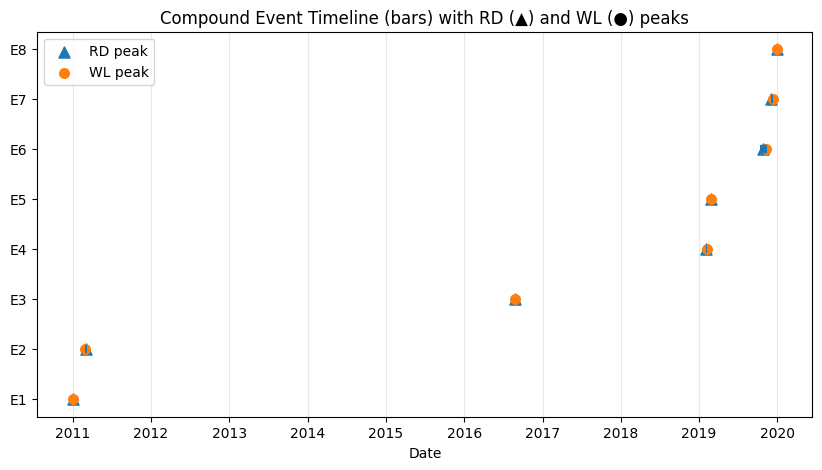

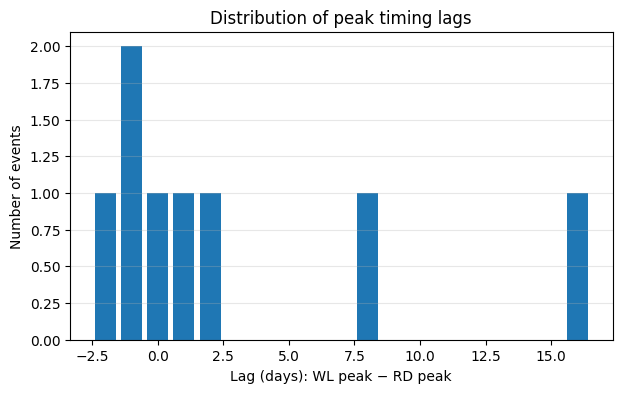

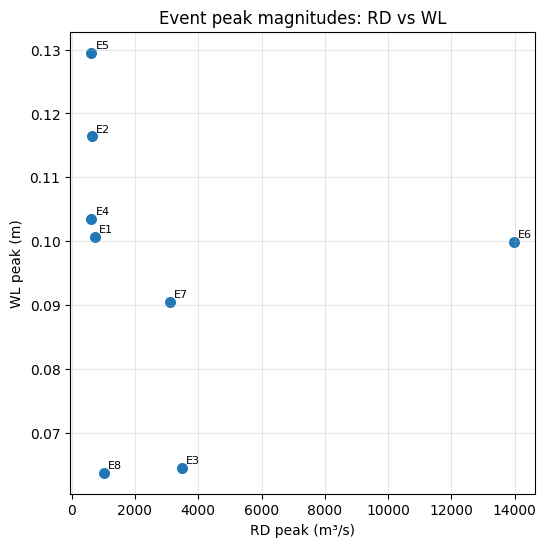

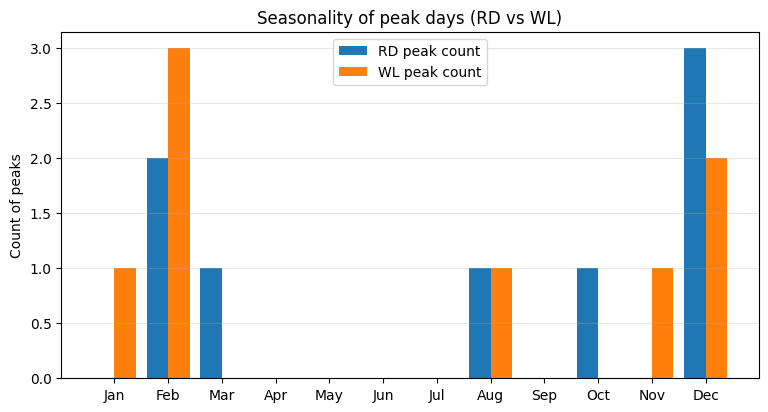

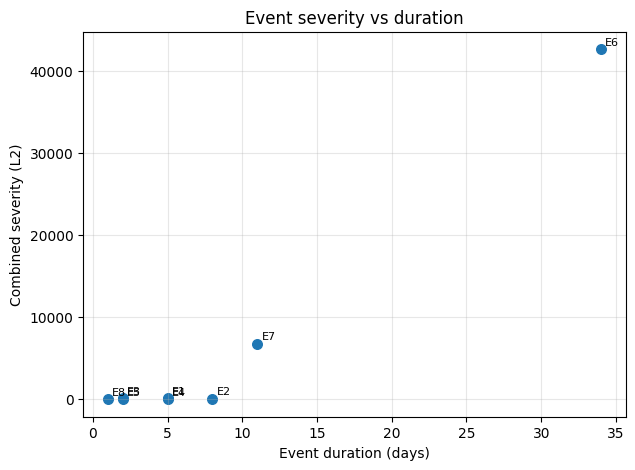

In [ ]:
plot_timeline(events)
plot_lag_distribution(events)
plot_joint_intensity(events)
plot_seasonality(events)
plot_duration_vs_severity(events)
